


# Prediction Of Equipment Failure:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sn

plt.style.use('fivethirtyeight')
import warnings

warnings.filterwarnings("ignore")

import itertools
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import precision_score,recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score


from xgboost import XGBClassifier
from xgboost import plot_importance



from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
from tensorflow.keras.callbacks import EarlyStopping




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading The Data 

In [56]:


df=pd.read_csv('/content/drive/My Drive/falls/equip_failures_training_set.csv')
df.head()

id  target  ...  sensor106_measure sensor107_measure
0   1       0  ...                  0                 0
1   2       0  ...                  0                 0
2   3       0  ...                  0                 0
3   4       0  ...                  4                32
4   5       0  ...                  0                 0

[5 rows x 172 columns]

In [57]:
# Lot of columns values are 'na' change this nan
df = df.replace('na',np.nan)

In [58]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col])
df.dtypes.head(10)

id                          int64
target                      int64
sensor1_measure             int64
sensor2_measure           float64
sensor3_measure           float64
sensor4_measure           float64
sensor5_measure           float64
sensor6_measure           float64
sensor7_histogram_bin0    float64
sensor7_histogram_bin1    float64
dtype: object

## Plotting the distribution of Classes:

The surface faults are : 59000 The percentage is : 98.33333333333333 %
The downhole faults are : 1000 The percentage is : 1.6666666666666667 %


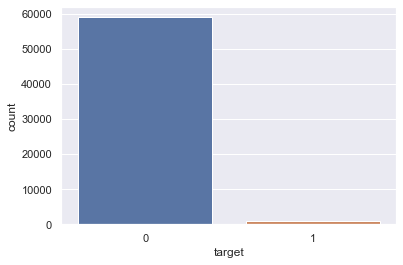

In [ ]:

sns.set_theme(style="darkgrid")
count=df['target'].value_counts()
print('The surface faults are :',count[0] ,'The percentage is :',count[0]/(count[0]+count[1])*100 ,'%')
print('The downhole faults are :',count[1] ,'The percentage is :',count[1]/(count[0]+count[1])*100 ,'%')
ax = sns.countplot(x="target", data=df)

### It can be observed that the data is highly imbalanced here .Generally it any model will have a high bias towards the surface fault.We have to mitigate this problem by oversampling .

### Filtering out the time based filters 

In [19]:
sensors=[l for l in df.columns if 'histogram' in l]
time_sensor=[]
for i in sensors:
    time_sensor.append(i.split('_')[0])
time_sensor=set(time_sensor)
time_sensor=list(time_sensor)
print('The time based sensors are :',time_sensor)

The time based sensors are : ['sensor105', 'sensor64', 'sensor24', 'sensor69', 'sensor7', 'sensor25', 'sensor26']


###  Performing EDA On Time based sensors:

The histogram data of sensor69


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


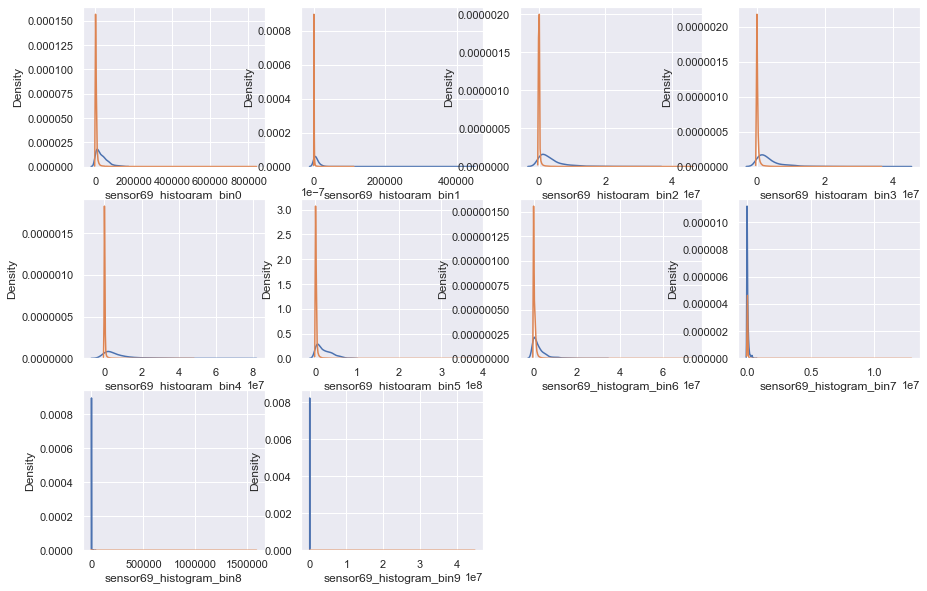

The histogram data of sensor25


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


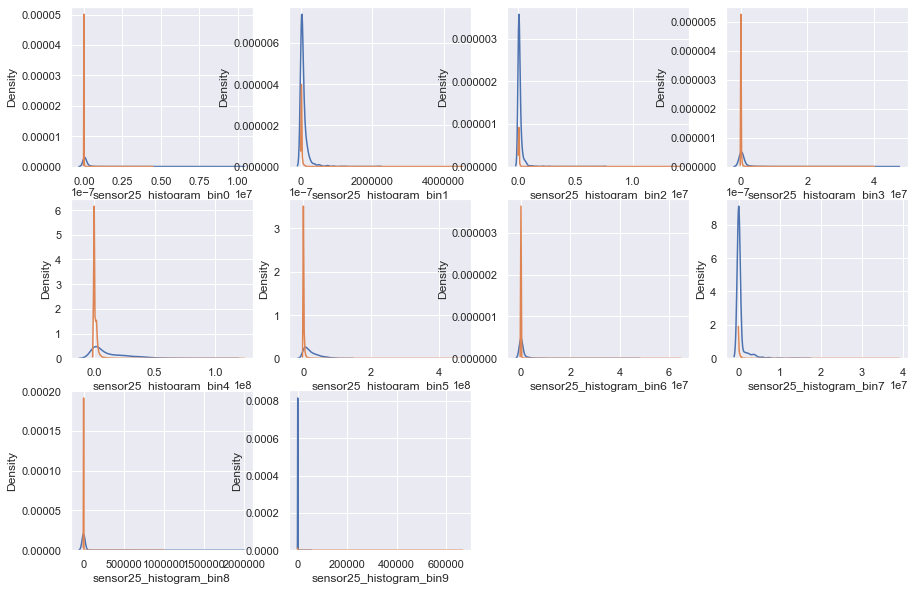

The histogram data of sensor64


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


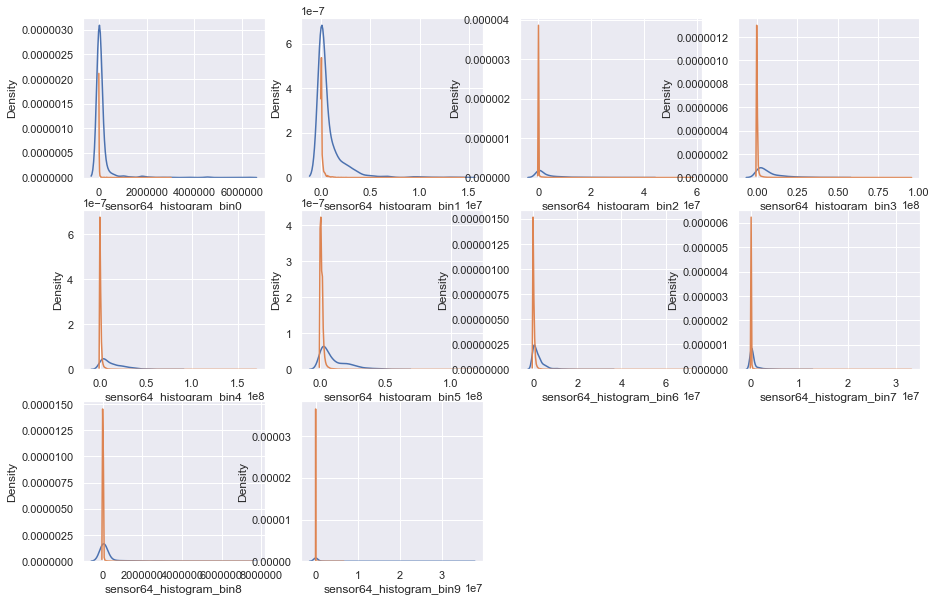

The histogram data of sensor26


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


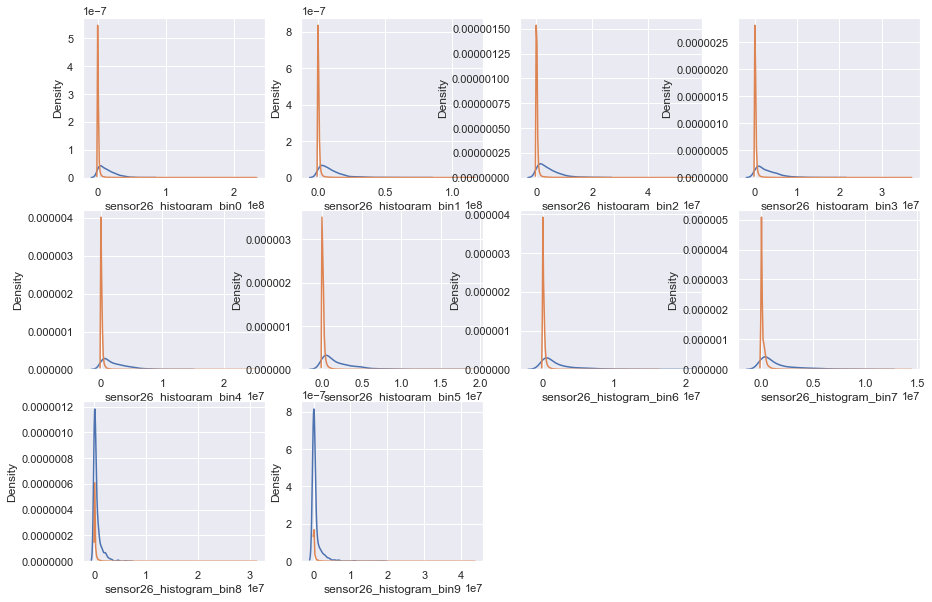

The histogram data of sensor7


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


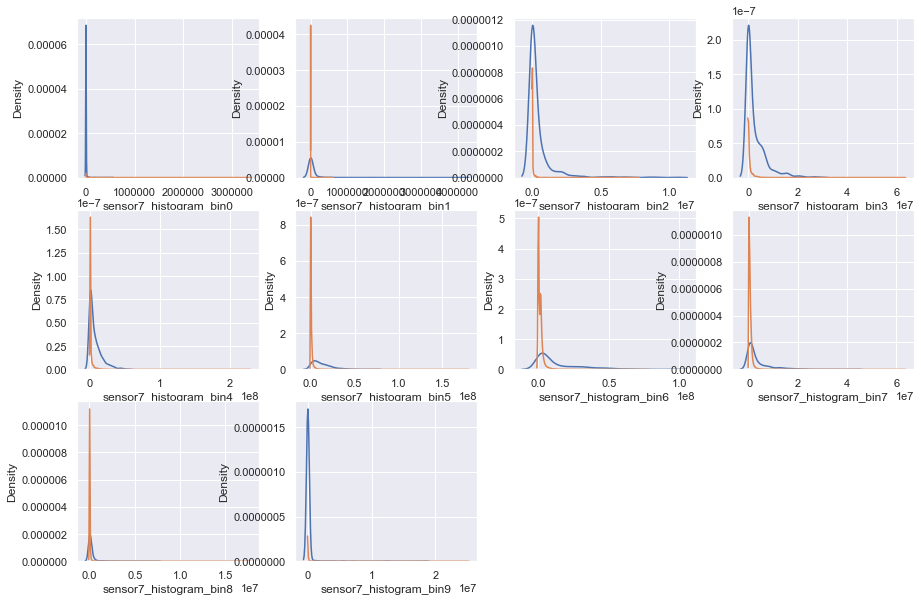

The histogram data of sensor105


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


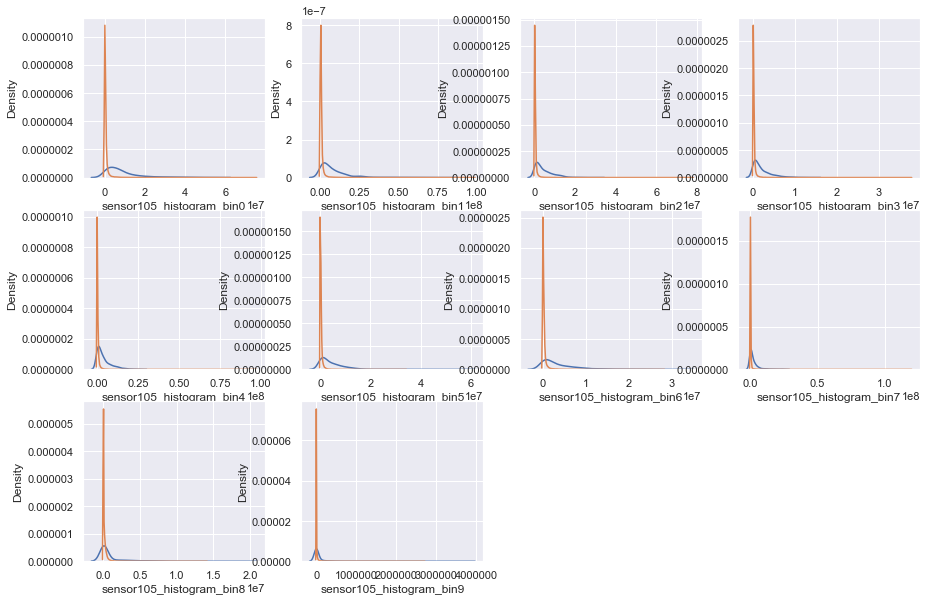

The histogram data of sensor24


/Users/sarangsonar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


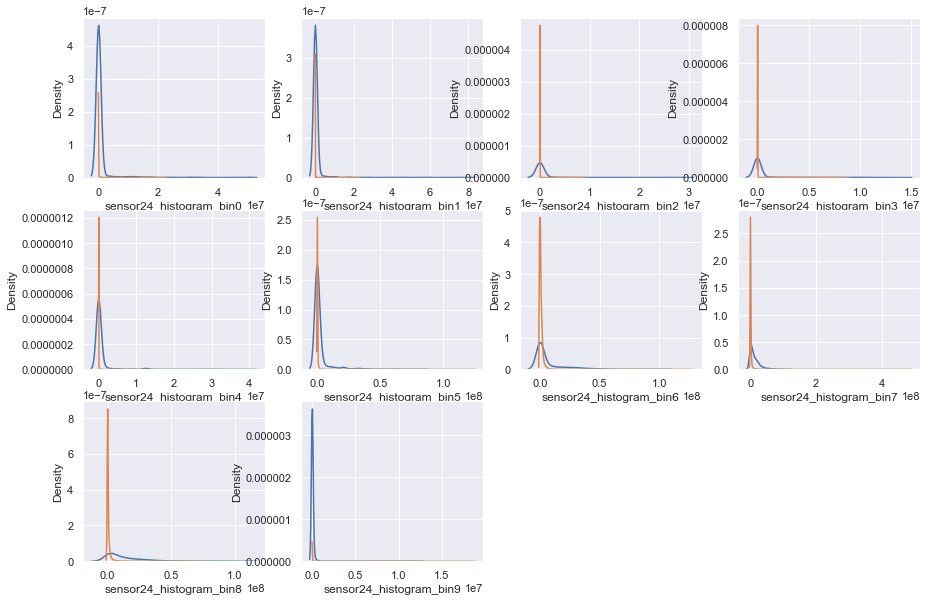

In [ ]:
for i in range(len(time_sensor)):
    print('The histogram data of {}'.format(time_sensor[i]))
    col = [l for l in sensors if time_sensor[i] in l]
    temp=df[col]
    temp['target'] = df.iloc[:,1]
    
    ncols=4
    nrows=3
    fig, axs = plt.subplots(figsize=(15,10), ncols=4, nrows=3)
    sns.set(font_scale = 1.0)
    for i,ax in zip(range(10),axs.flat):
        temp_down = temp[temp['target']==1].iloc[:,i]
        temp_sur = temp[temp['target']==0].iloc[:,i]
        sns.kdeplot(temp_down,ax=ax, label='Downhole_fault')
        sns.kdeplot(temp_sur,ax=ax,label='Surface_fault')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper center')
    fig.delaxes(axs[nrows-1][ncols-2])
    fig.delaxes(axs[nrows-1][ncols-1])
    plt.show()
    

   

### Observation:
- 1)There is spike in certain sensor  values when there is a downhole fault ,therefore we can select those plots with minimum overlap .Therefore the sensors for detecting downhole fault are :sensor 69 bin1,sensor 25 bin0,sensor 64 bin2,sensor64 bin9,sensor 105 bin9.

- 2) Sensors for detecting surface fault are :
-     sensor 25 bin0,sensor7 bin0,sensor 7 bin9,sensor24 bin9

### Plotting the sensor result  along the time axis

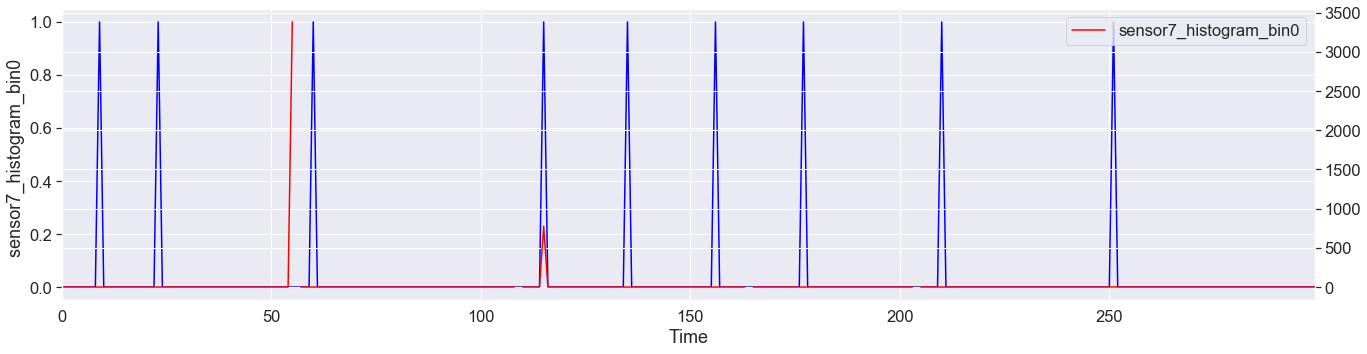

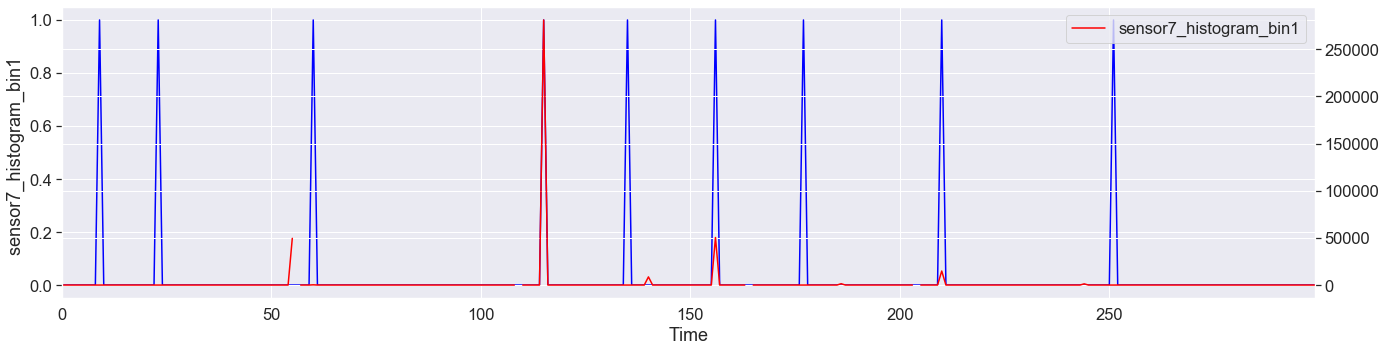

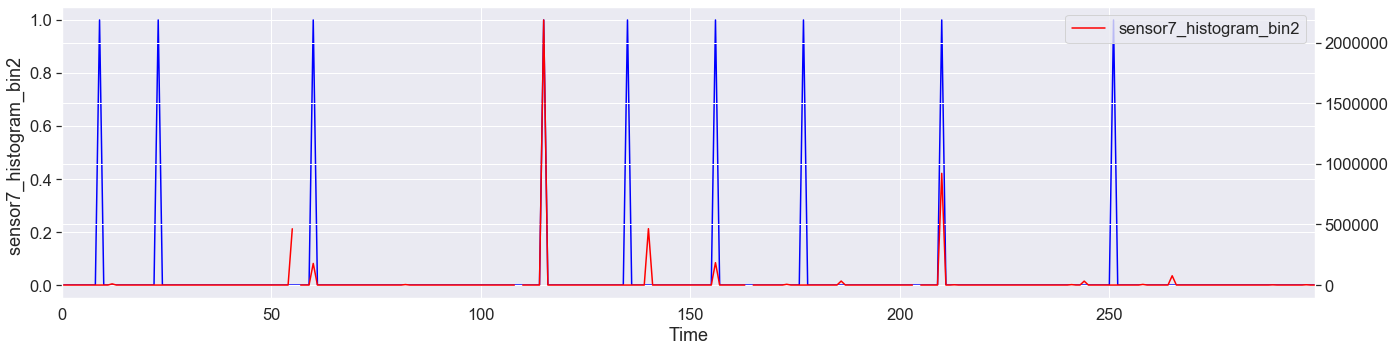

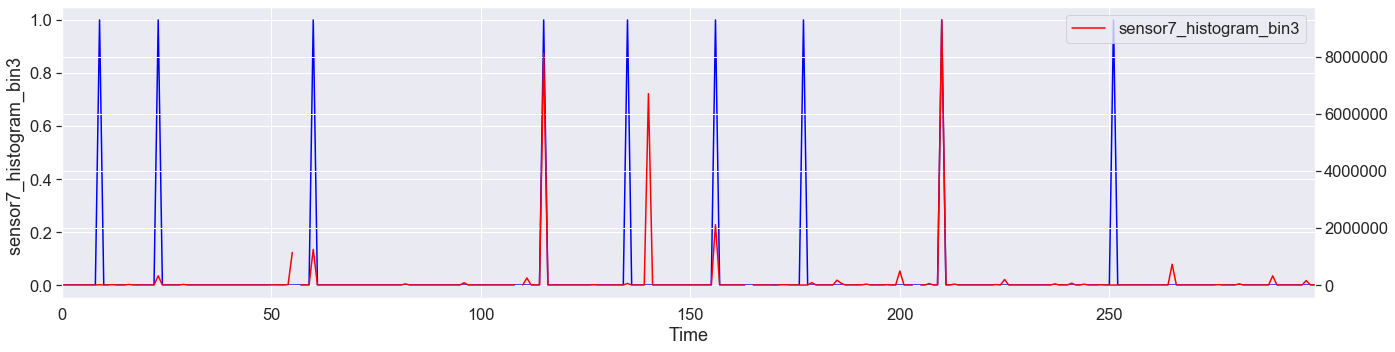

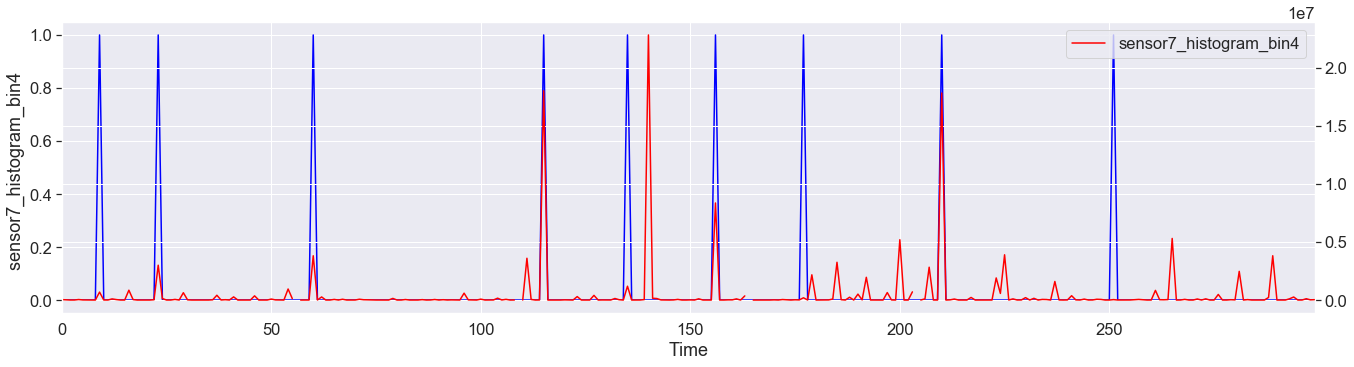

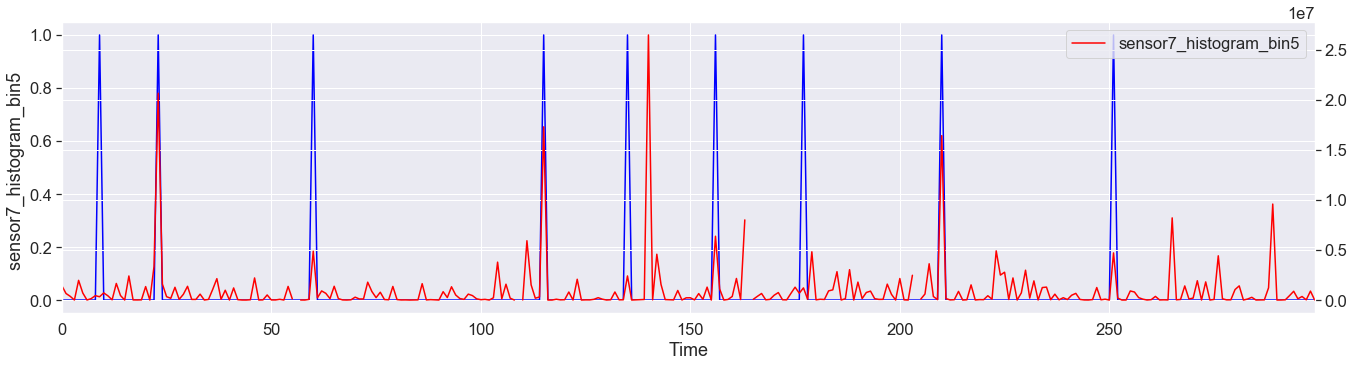

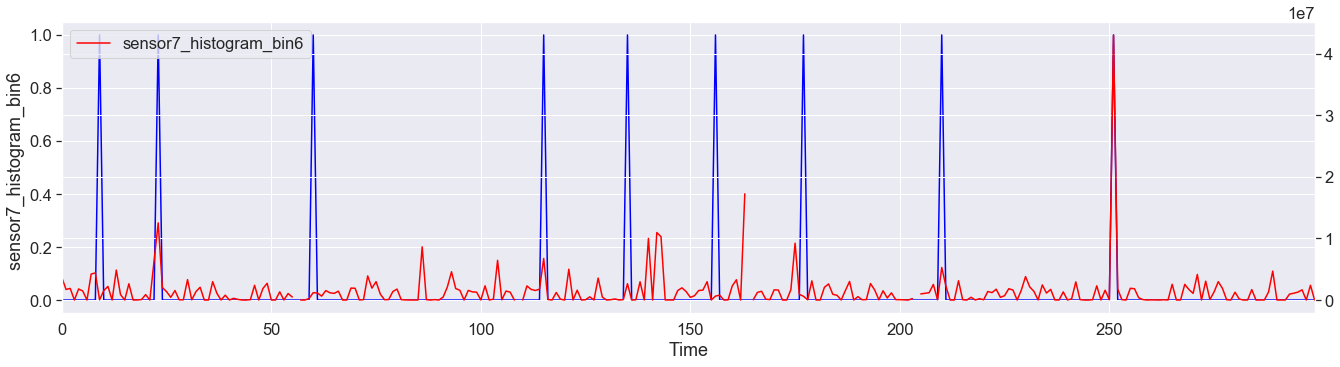

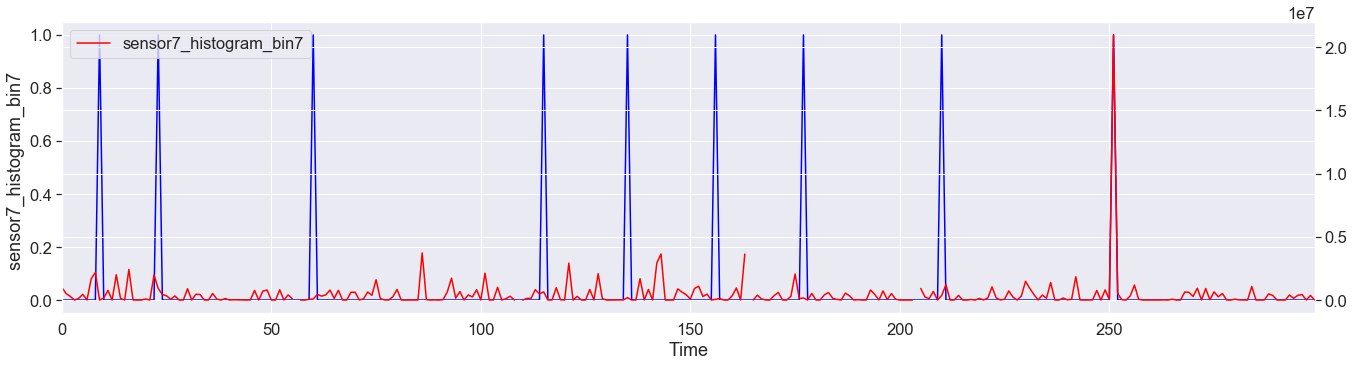

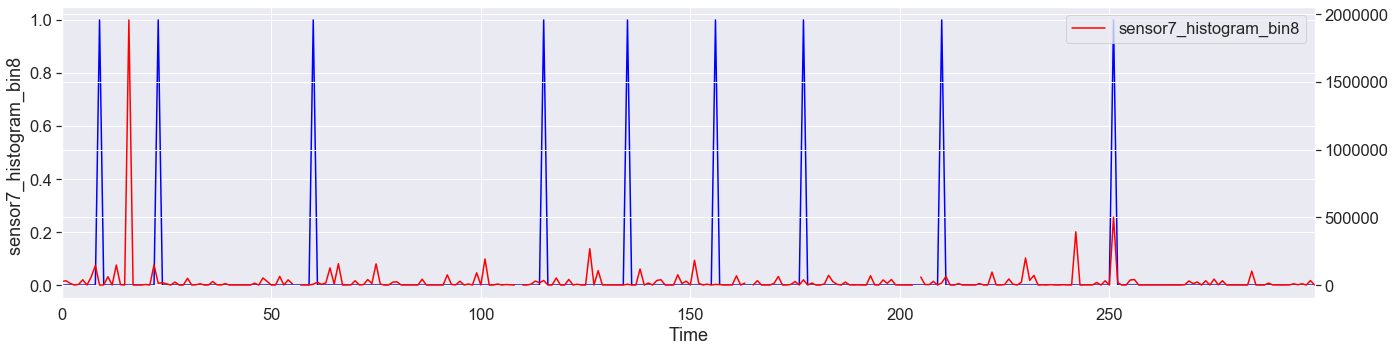

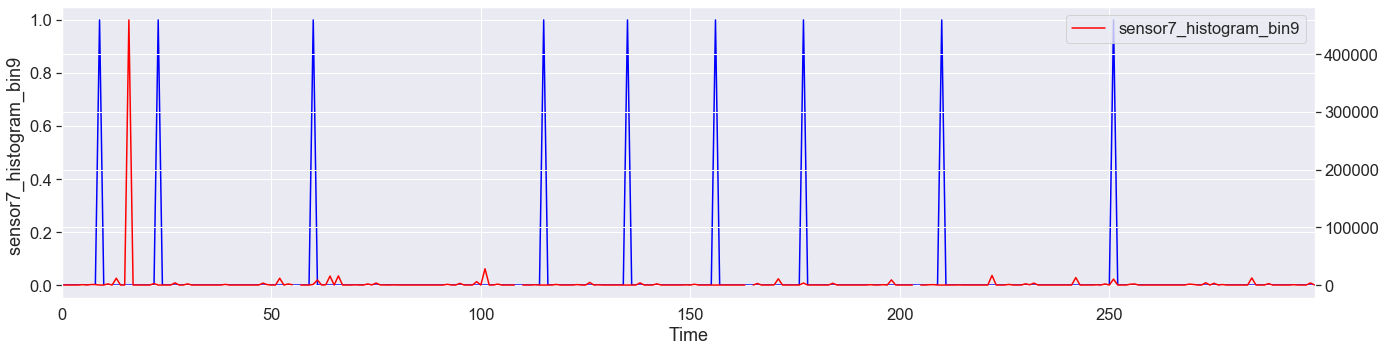

In [ ]:
for i in sensors[0:10]:
    rolling_mean = df[i][0:300]
    original=df['target'][0:300]
    
    
    sns.set(font_scale = 1.5)
    fig=plt.figure(figsize=(20,5))
    ax1=fig.add_subplot(111)
    ax2=ax1.twinx()
    ax1.set_ylabel('{} '.format(i))
    ax1.set_xlabel('Time')
    original.plot(color='blue',ax=ax1,label='fault_type')
    rolling_mean.plot(color='red',ax=ax2,label=i)
    plt.legend()
    plt.show()

### Observation:

### The data has been observed for the 300 points keeping in mind the ratio of class distribution

- Downhole faults are represented by 1 and the surface faults are represented by 0 in the blue line .

- For downhole fault we can see that sensor 7 bin4 ,sensor7 bin3,sensor 25 bin2 ,sensor25 bin3 ,sensor 26 bin1,sensor 26 bin3 ,sensor64 bin4,sensor 69 bin0,sensor 69 bin2 can be good features .They are spiking up when the downhole fault is occuring .

- For surface fault the best features are sensor 7 Bin8,sensor7 bin9,sensor 24 bin6,sensor 25 bin3,sensor 25 bin8,sensor 26 bin5,sensor64 bin1,sensor 64 bin5,sensor 64 bin6,sensor 69 bin0,sensor 69 bin8,sensor 69 bin 9

## Non_time based sensors:

In [ ]:
non_time_sensors=df.drop(sensors,axis=1)

In [ ]:
non_time_sensors.head()

id  target  sensor1_measure  sensor2_measure  sensor3_measure  \
0   1       0            76698              NaN     2.130706e+09   
1   2       0            33058              NaN     0.000000e+00   
2   3       0            41040              NaN     2.280000e+02   
3   4       0               12              0.0     7.000000e+01   
4   5       0            60874              NaN     1.368000e+03   

   sensor4_measure  sensor5_measure  sensor6_measure  sensor8_measure  \
0            280.0              0.0              0.0        2551696.0   
1              NaN              0.0              0.0        1393352.0   
2            100.0              0.0              0.0        1234132.0   
3             66.0              0.0             10.0           2668.0   
4            458.0              0.0              0.0        1974038.0   

   sensor9_measure  ...  sensor97_measure  sensor98_measure  sensor99_measure  \
0              0.0  ...         1876644.0               0.0               0.0   
1              0.0  ...          868538.0               0.0               0.0   
2              0.0  ...           48028.0               0.0               0.0   
3              0.0  ...            1822.0           20174.0              44.0   
4              0.0  ...           80482.0           98334.0           27588.0   

   sensor100_measure  sensor101_measure  sensor102_measure  sensor103_measure  \
0                0.0                0.0          2801180.0            2445.80   
1                0.0                0.0          3477820.0            2211.76   
2                0.0                0.0          1040120.0            1018.64   
3                0.0                0.0                0.0               1.08   
4                0.0                0.0         21173050.0            1116.06   

   sensor104_measure  sensor106_measure  sensor107_measure  
0             2712.0                0.0                0.0  
1             2334.0                0.0                0.0  
2             1020.0                0.0                0.0  
3               54.0                4.0               32.0  
4             1176.0                0.0                0.0  

[5 rows x 102 columns]

In [ ]:
column=list(non_time_sensors.columns)
del column[0:2]



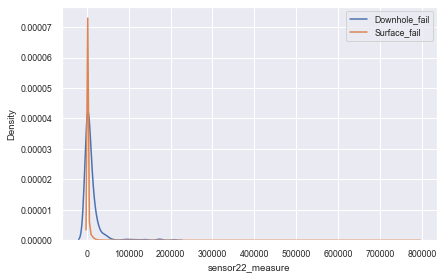

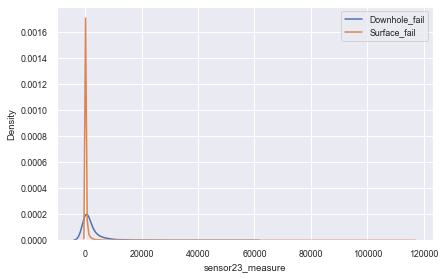

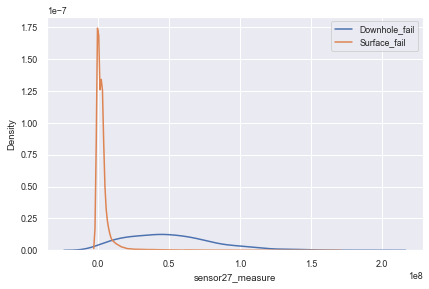

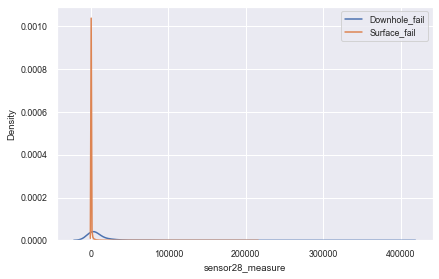

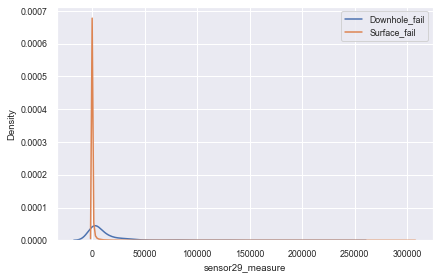

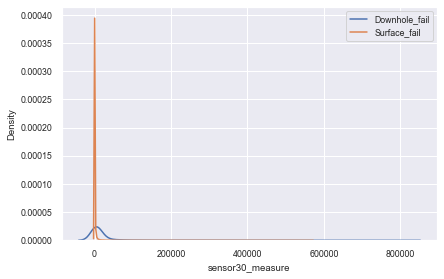

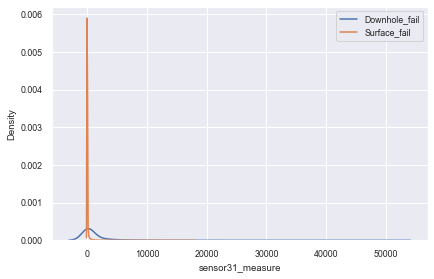

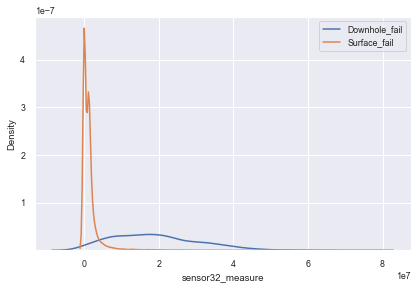

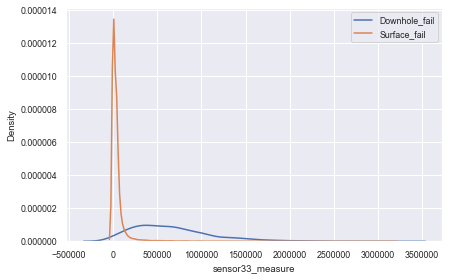

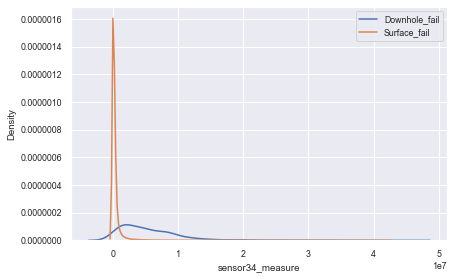

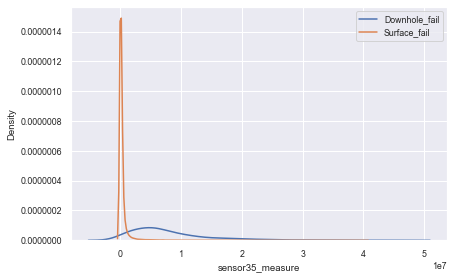

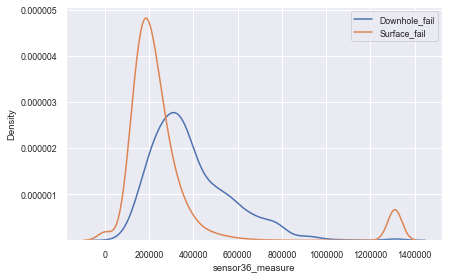

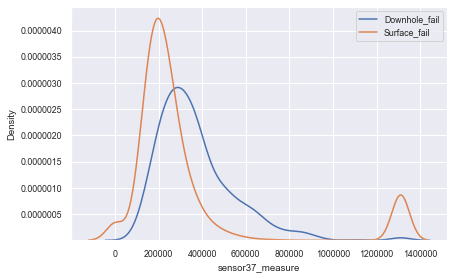

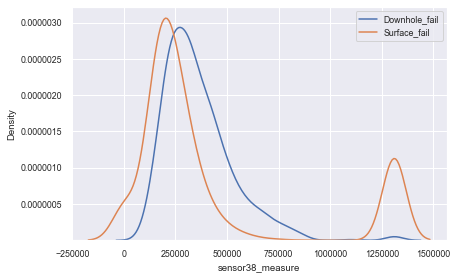

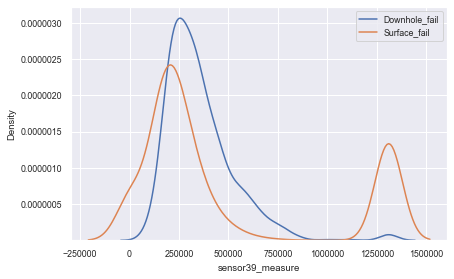

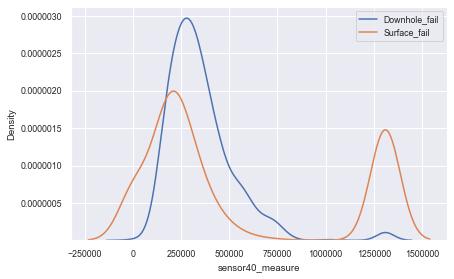

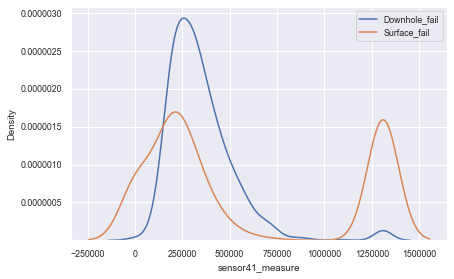

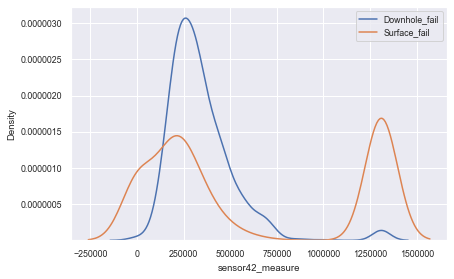

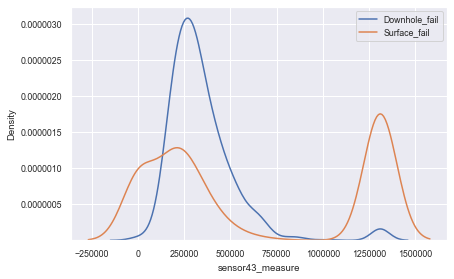

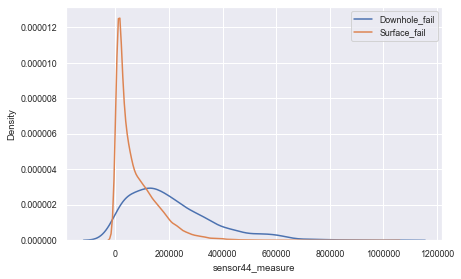

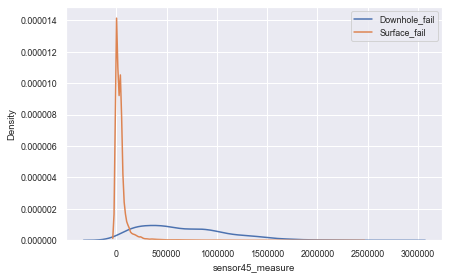

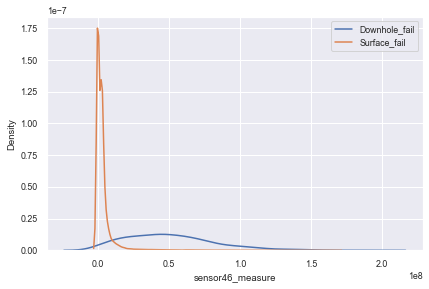

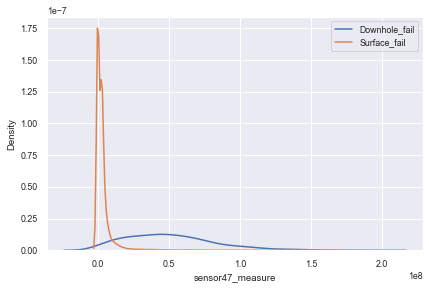

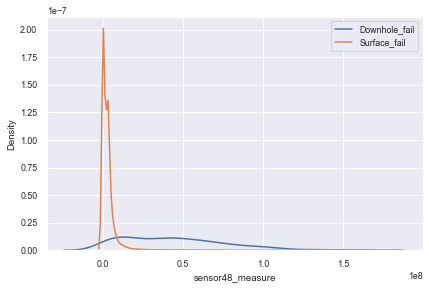

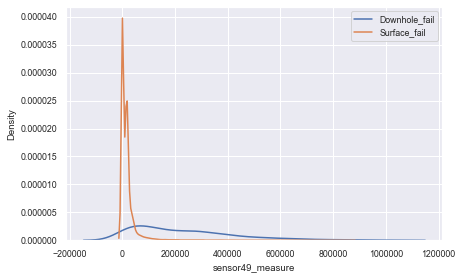

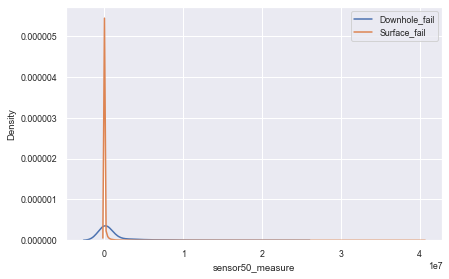

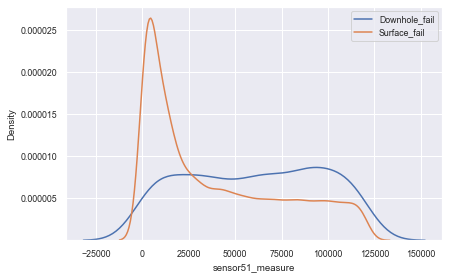

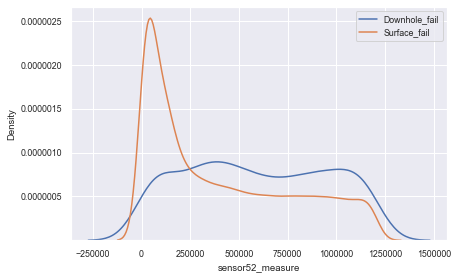

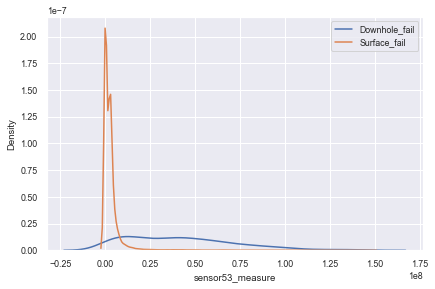

No handles with labels found to put in legend.


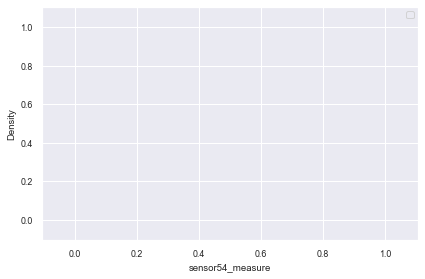

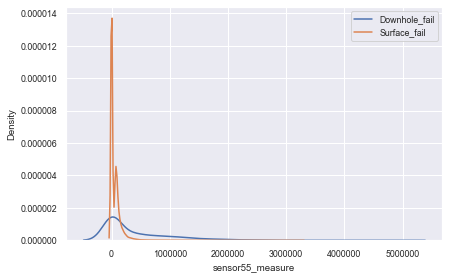

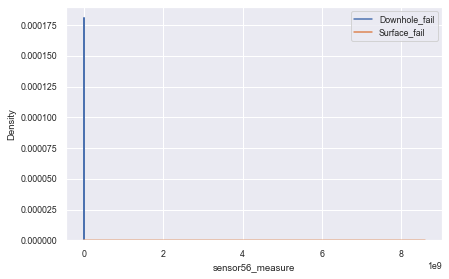

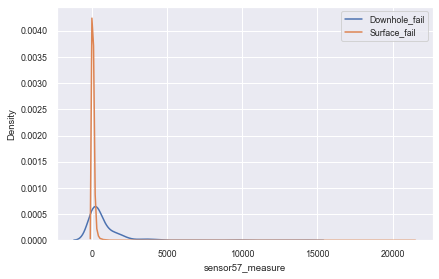

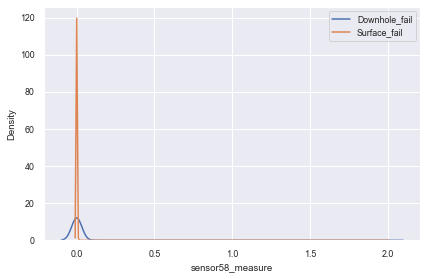

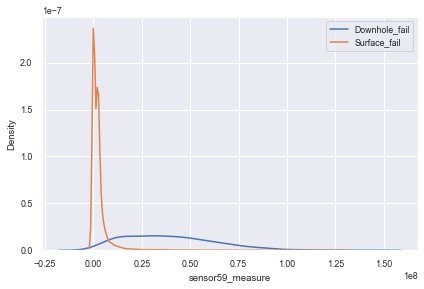

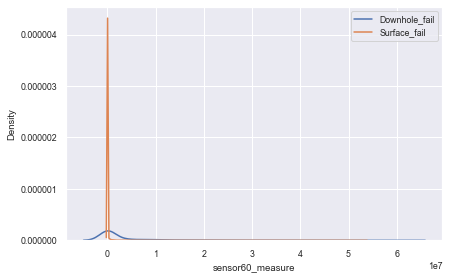

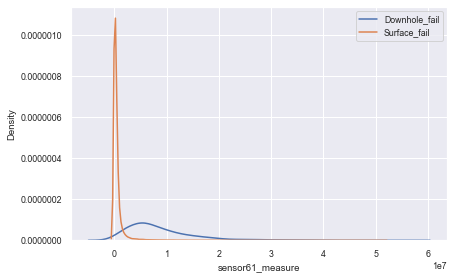

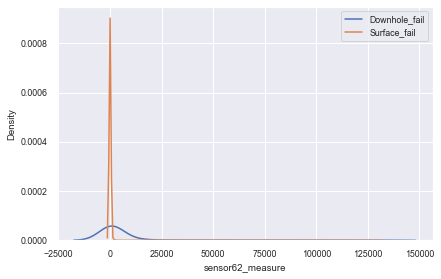

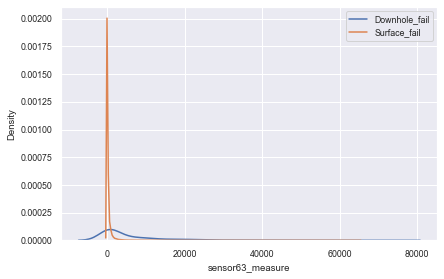

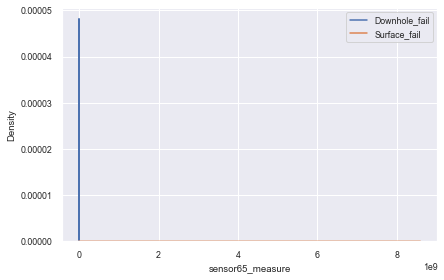

In [ ]:
from tqdm.notebook import tqdm



for i in tqdm(column[20:60]):
    #the rows which are marked as downhole fault
    downhole_fault=df[df['target']==1][i]
    #the rows which are marked as surface fault
    surface_fault=df[df['target']==0][i]
    sns.kdeplot(downhole_fault, label='Downhole_fail')
    sns.kdeplot(surface_fault,label='Surface_fail')
    plt.legend()
    plt.show()


### Observation:
- Over here it can be seen that sensor8,sensor 17,sensor27,sensor 32,sensor 45 ,sensor46,sensor53 are having the least overlap .
- These sensors are going to play a major role in classifying the different faults.

## Using Statistical Methods  On Time Based Sensors For Feature Engineering :


### Using Simple Moving Average (SMA)

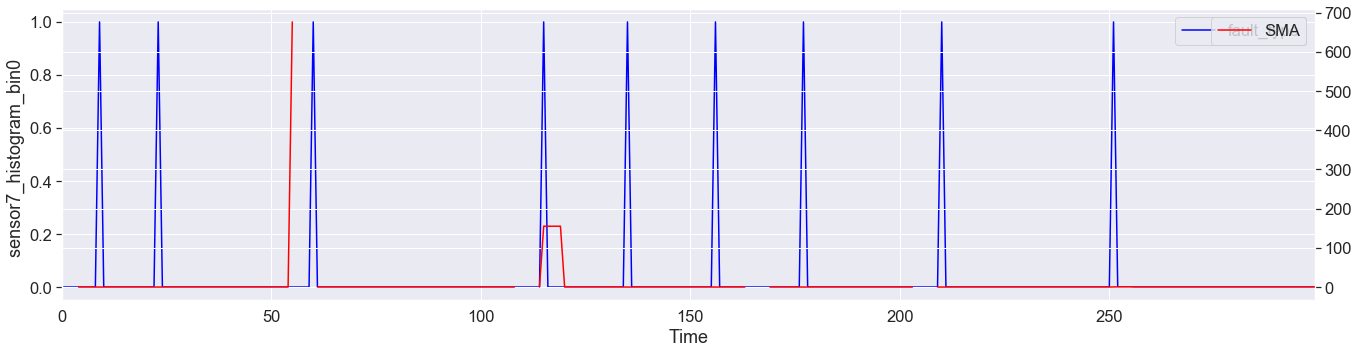

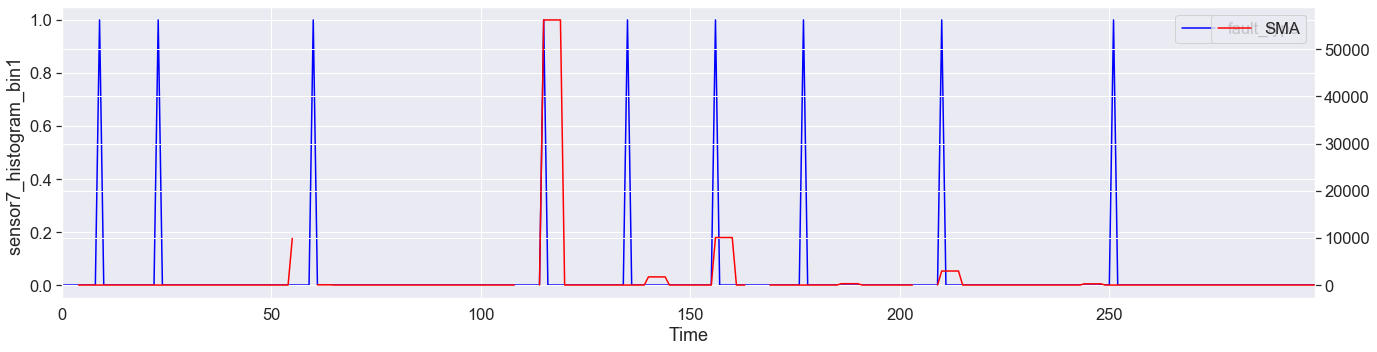

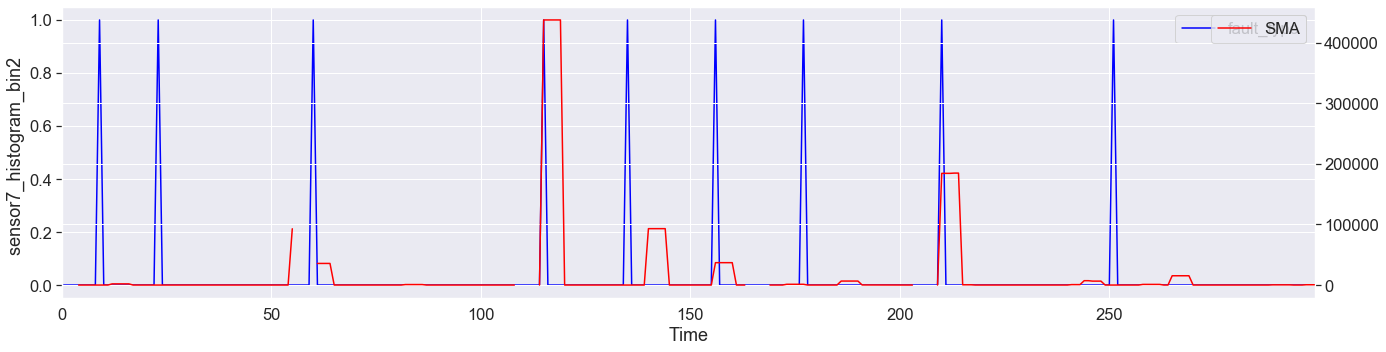

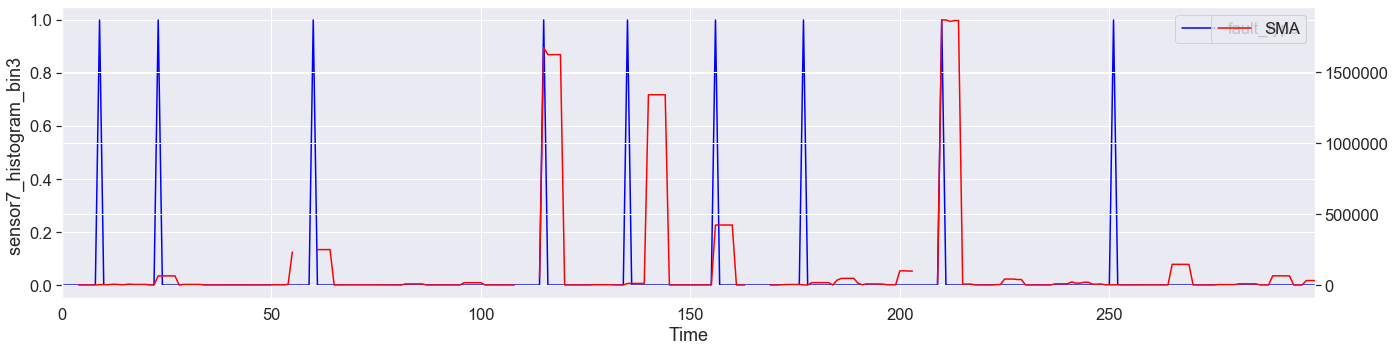

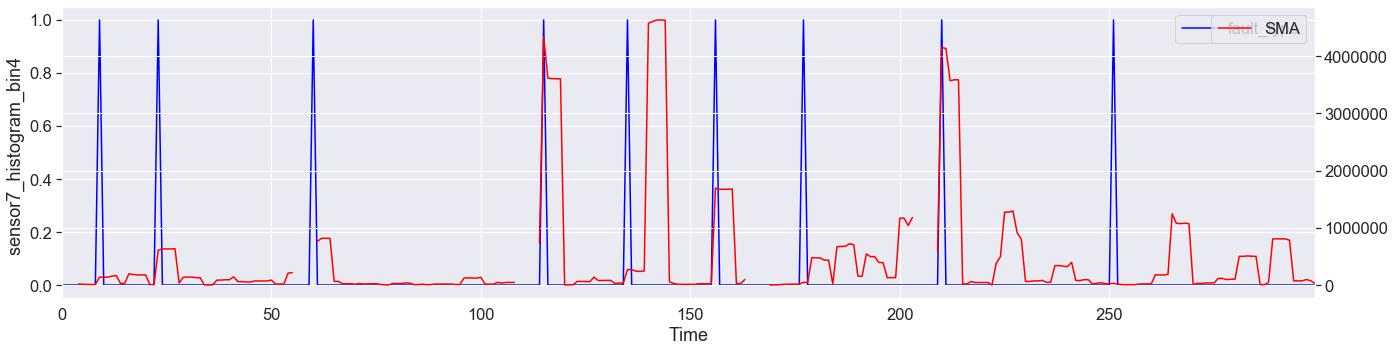

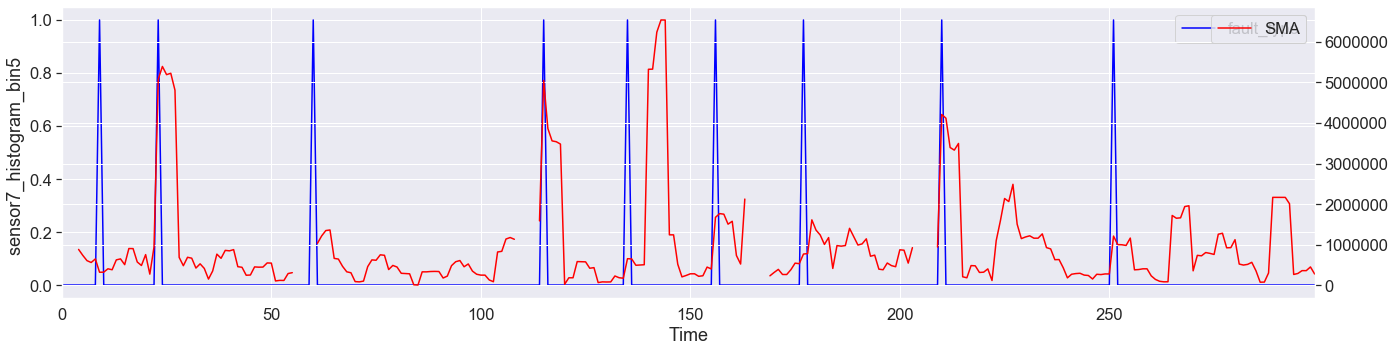

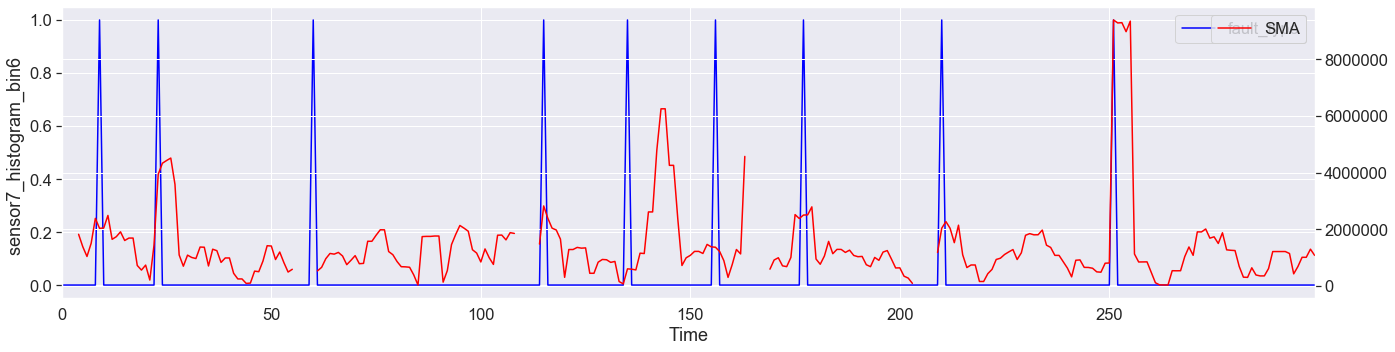

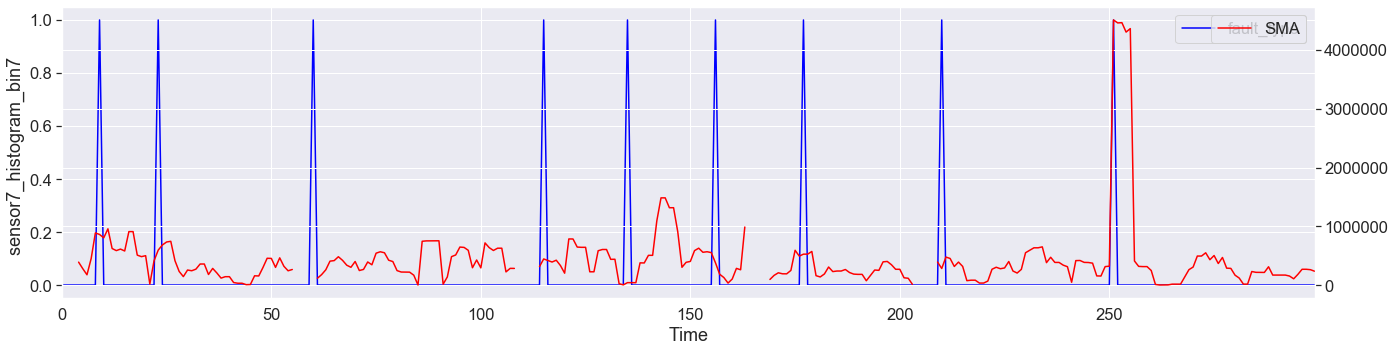

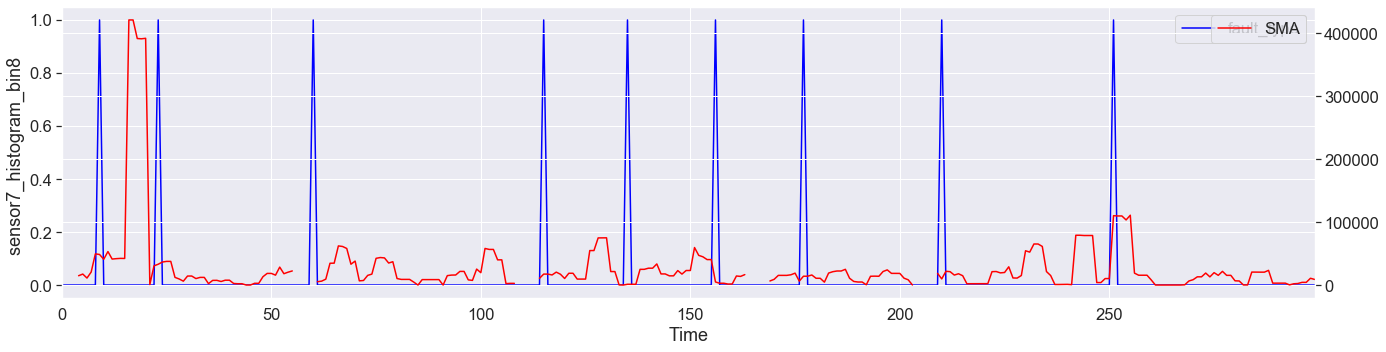

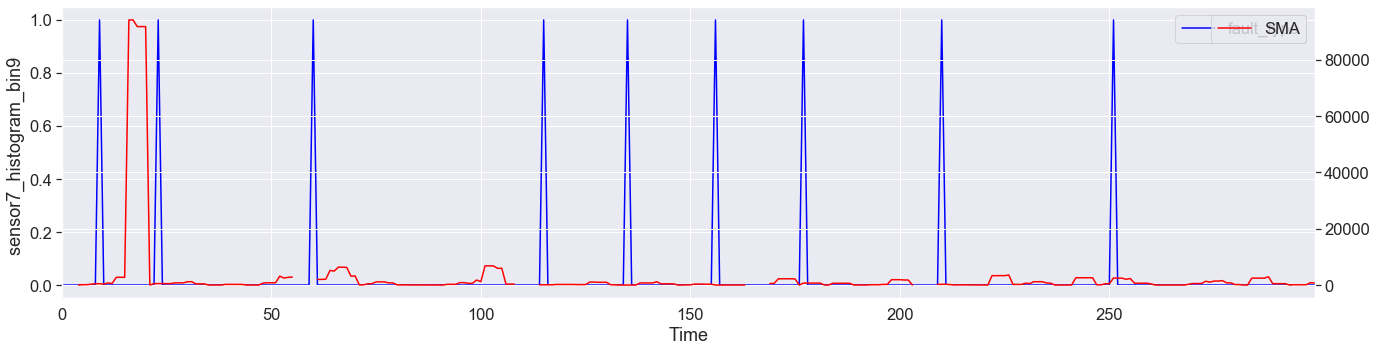

In [ ]:
## using Simple Moving Averages SMA

for i in sensors[0:10]:
    rolling_mean = df[i][0:300].rolling(window =5).mean()
    original=df['target'][0:300]
    
    
    sns.set(font_scale = 1.5)
    fig=plt.figure(figsize=(20,5))
    ax1=fig.add_subplot(111)
    ax2=ax1.twinx()
    ax1.set_ylabel('{} '.format(i))
    ax1.set_xlabel('Time')
    original.plot(color='blue',ax=ax1,label='fault_type')
    rolling_mean.plot(color='red',ax=ax2,label='SMA')
    
    ax1.legend()
    ax2.legend()
    plt.show()
    

### Observation:
- Best features which are matching  the fault type are:

- 'sensor7_histogram_bin0','sensor7_histogram_bin3','sensor25_histogram_bin2','sensor25_histogram_bin3','sensor25_histogram_bin6',
'sensor25_histogram_bin8','sensor26_histogram_bin1','sensor26_histogram_bin2','sensor26_histogram_bin3','sensor26_histogram_bin4','sensor69_histogram_bin4','sensor69_histogram_bin9'

#### Therefore these features can be added to out original dataset to get more accuracy.

## Using ARIMA   to Analyse the best Time Sensors:

In [ ]:
best_time_sensors=['sensor7_histogram_bin0','sensor7_histogram_bin3','sensor25_histogram_bin2','sensor25_histogram_bin3','sensor25_histogram_bin6','sensor25_histogram_bin8','sensor26_histogram_bin1','sensor26_histogram_bin2','sensor26_histogram_bin3','sensor26_histogram_bin4','sensor69_histogram_bin4','sensor69_histogram_bin9']





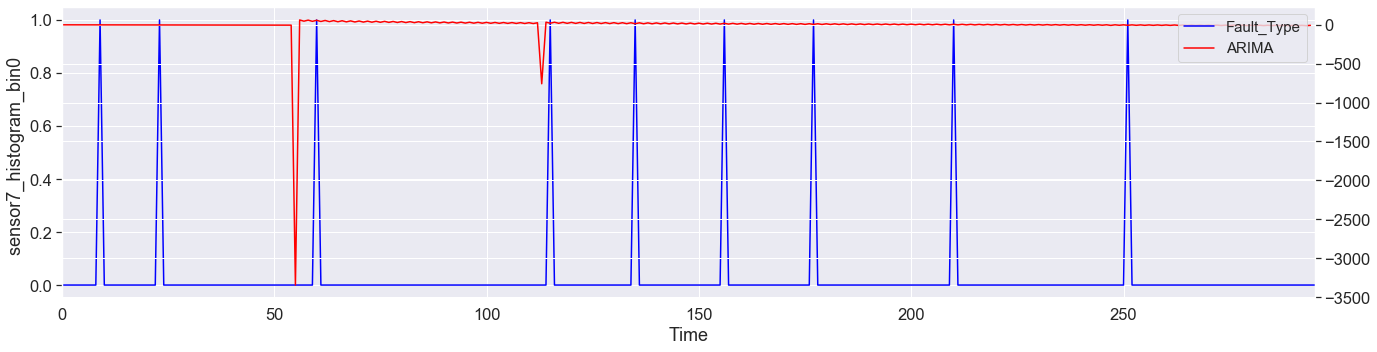

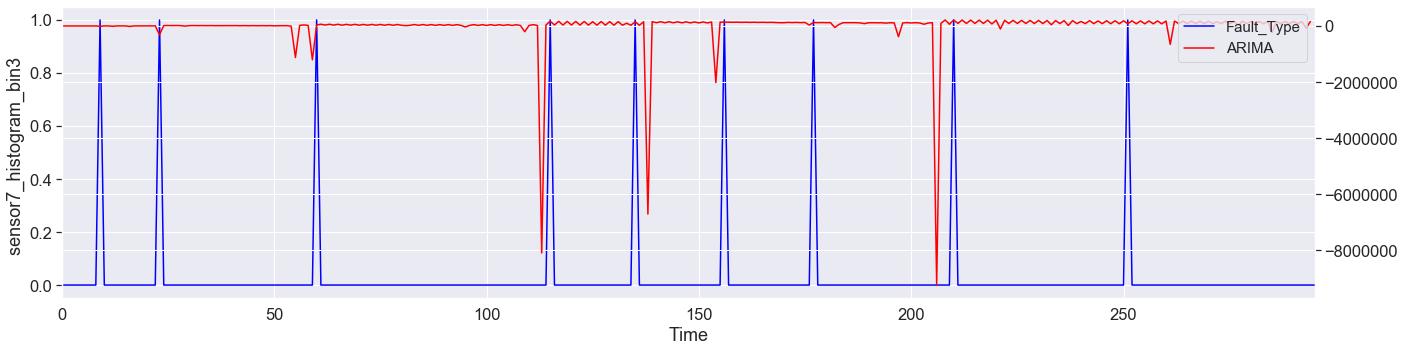

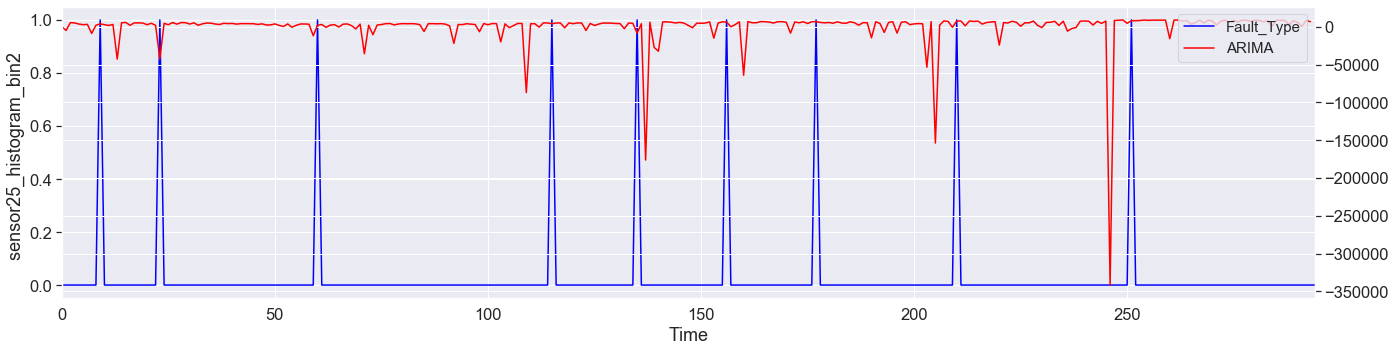

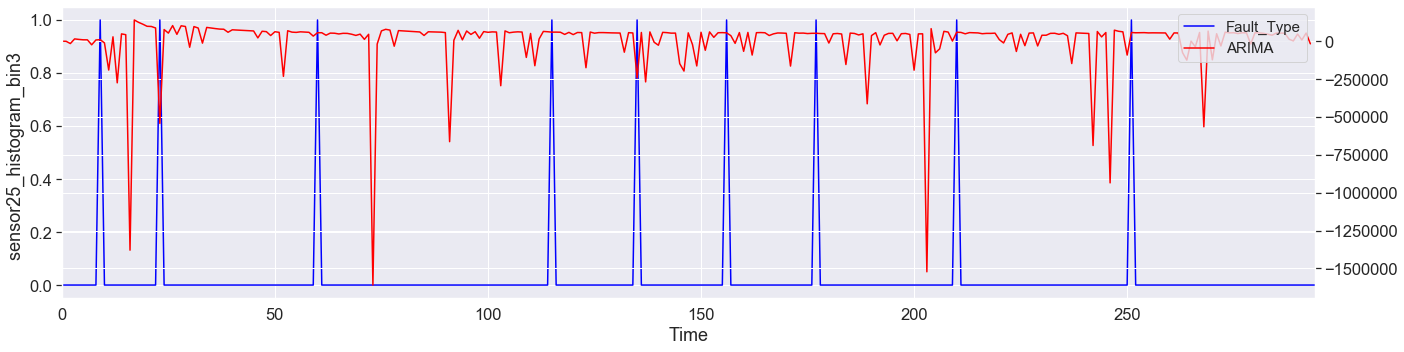

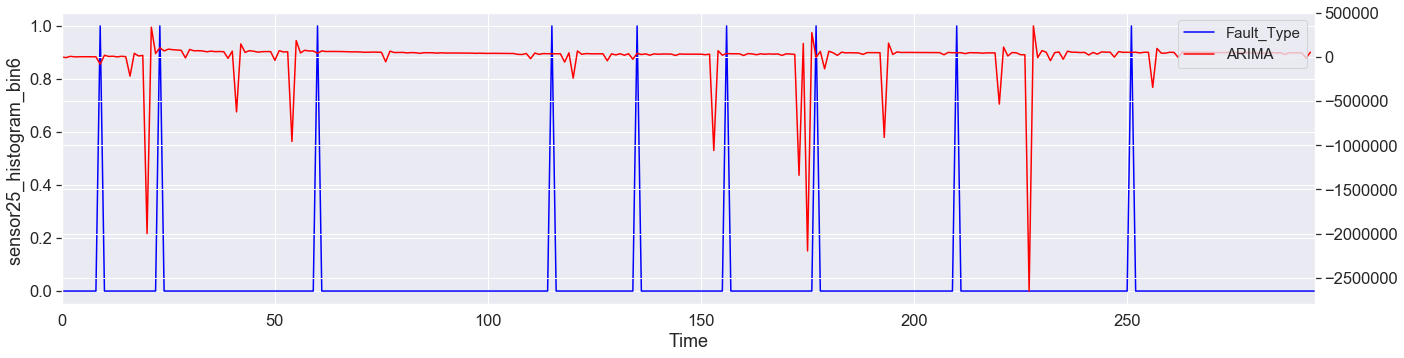

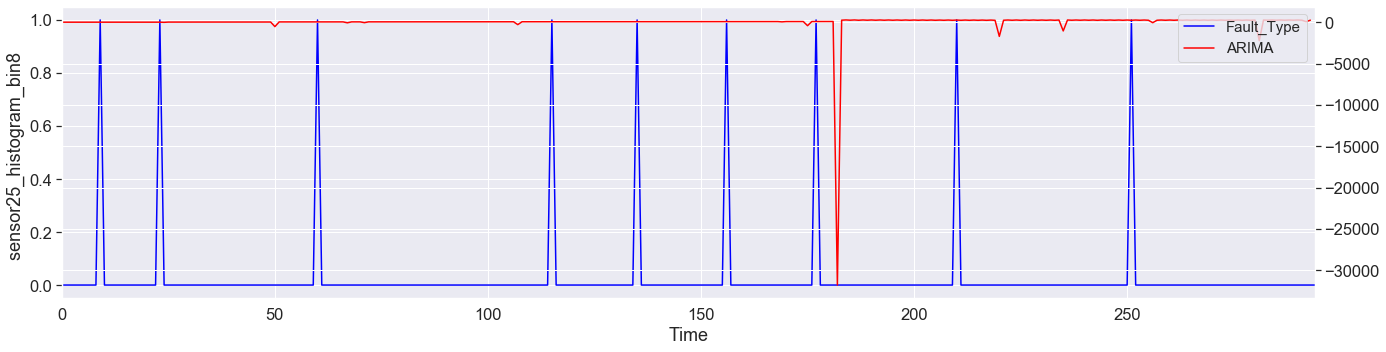

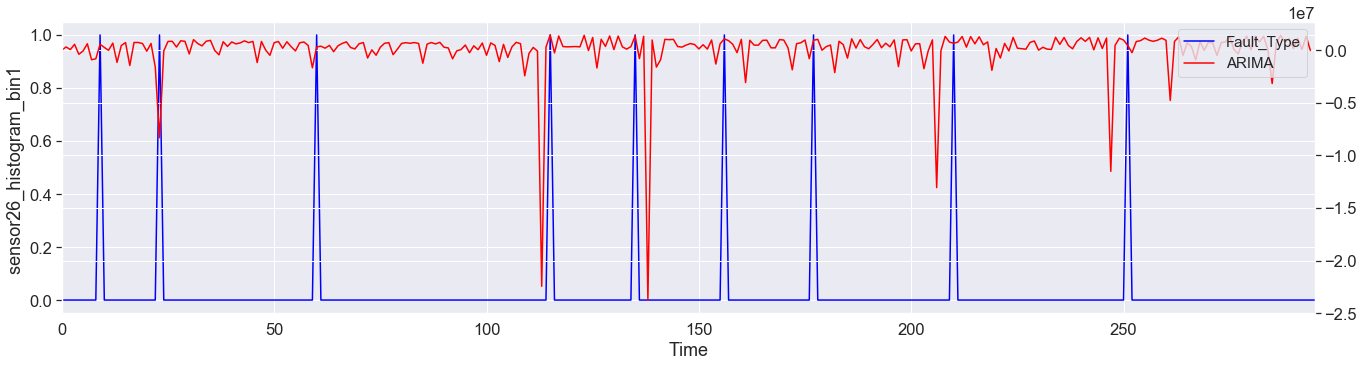

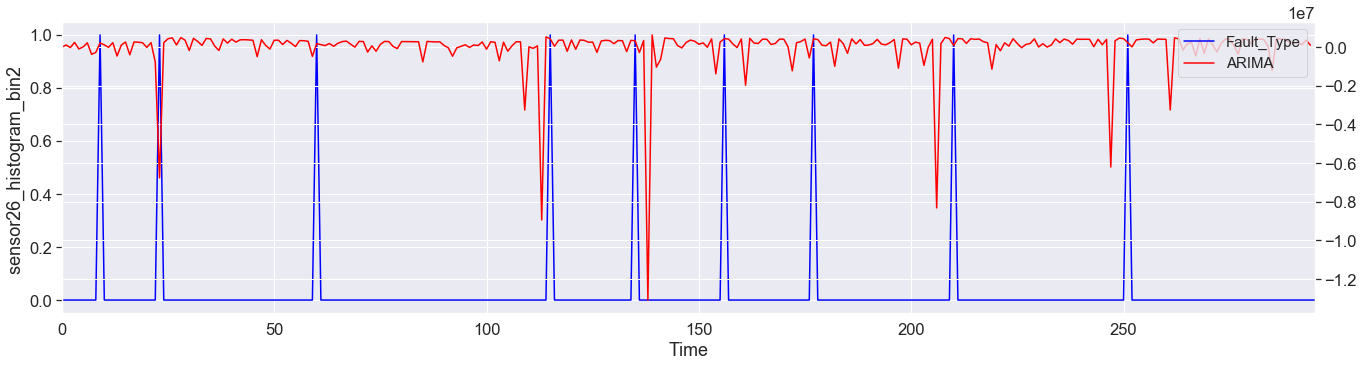

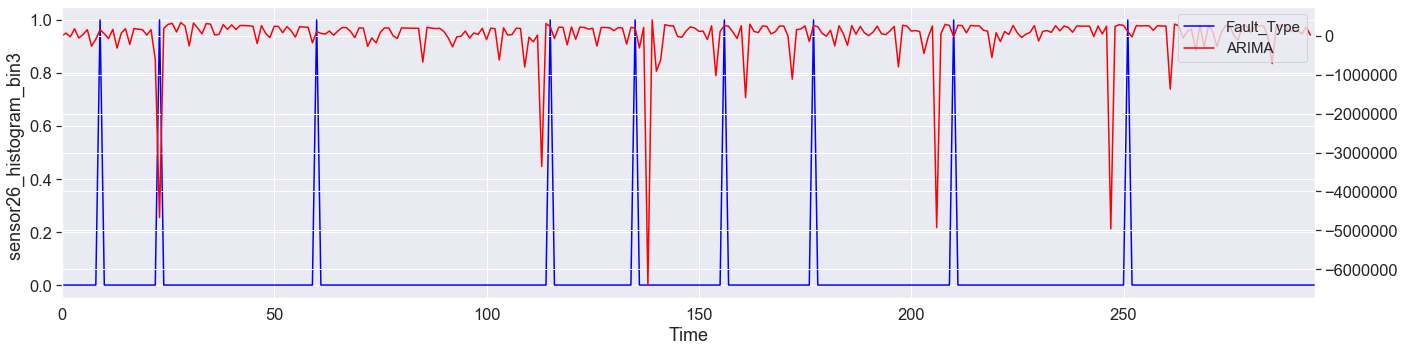

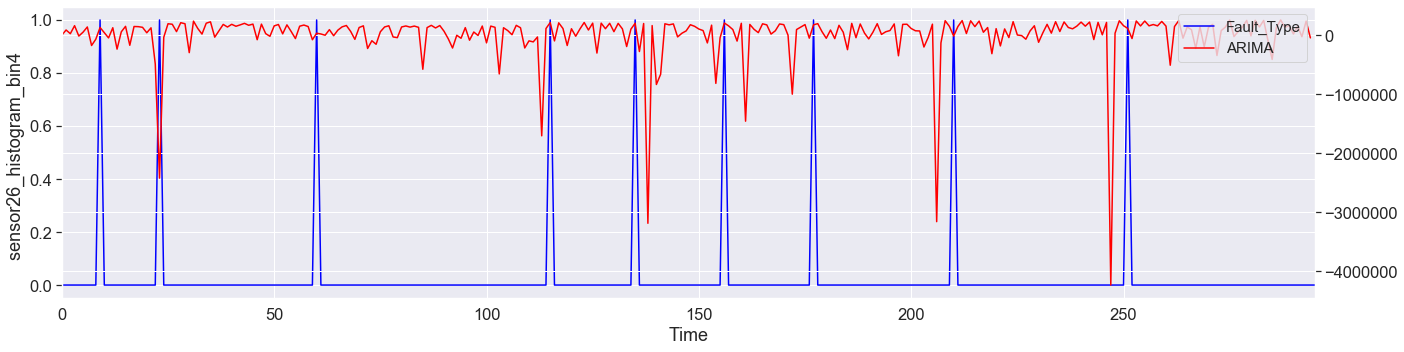

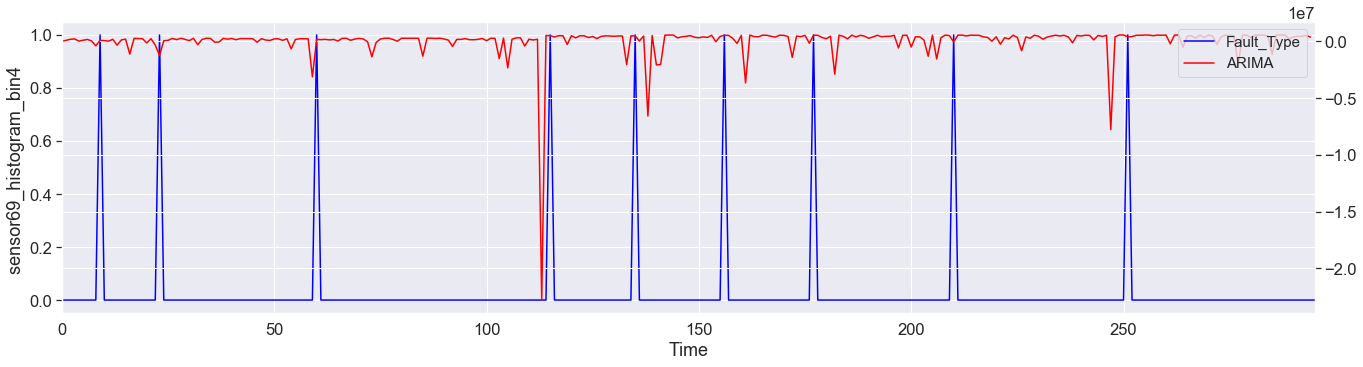

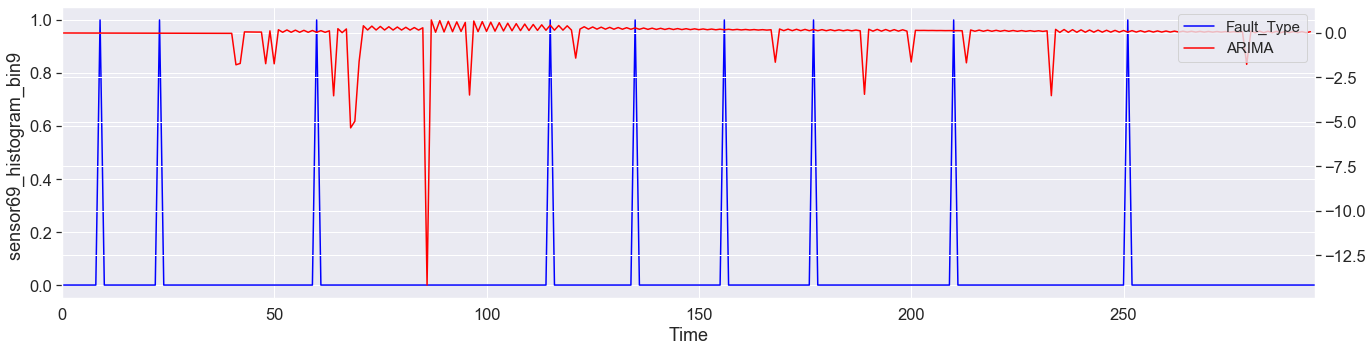

In [ ]:
#https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
for i in tqdm(best_time_sensors):
    d=df[i][0:300].dropna()
    l=len(d)
    d=np.array(d)
    model = ARIMA(d, order=(2, 1, 2))  
    results_ARIMA = model.fit(disp=1)  
    
    original=df['target'][0:l]
    
    
    sns.set(font_scale = 1.5)
    fig=plt.figure(figsize=(20,5))
    ax1=fig.add_subplot(111)
    ax2=ax1.twinx()
    ax1.set_ylabel('{} '.format(i))
    ax1.set_xlabel('Time')
    original.plot(color='blue',ax=ax1,label='Fault_Type')
    plt.plot(results_ARIMA.fittedvalues, color='red',label='ARIMA')
    
    ax1.legend()
    ax2.legend()
    plt.show()

### Observation:

- It can be seen that among the best features the ARMIA values of sensor 25 bin2,sensor 26 bin1,sensor26 bin2,sensor 26 bin3, become important for detecting the downhole fault.
- The surface fault can be detected by using sensor 25 bin3,sensor 25,bin6, sensor69 bin9.

#### Therefore these features can be added to out original dataset to get more accuracy.

## To calculate the Number of Nan values for each sesnors:

In [ ]:
num_of_nan=[]
l=[]
s=[]
for i in range(len(sensors)):
    x=df[sensors[i]].isna().sum()
    num_of_nan.append(x)
    l.append(i)
    s.append(sensors[i])
    



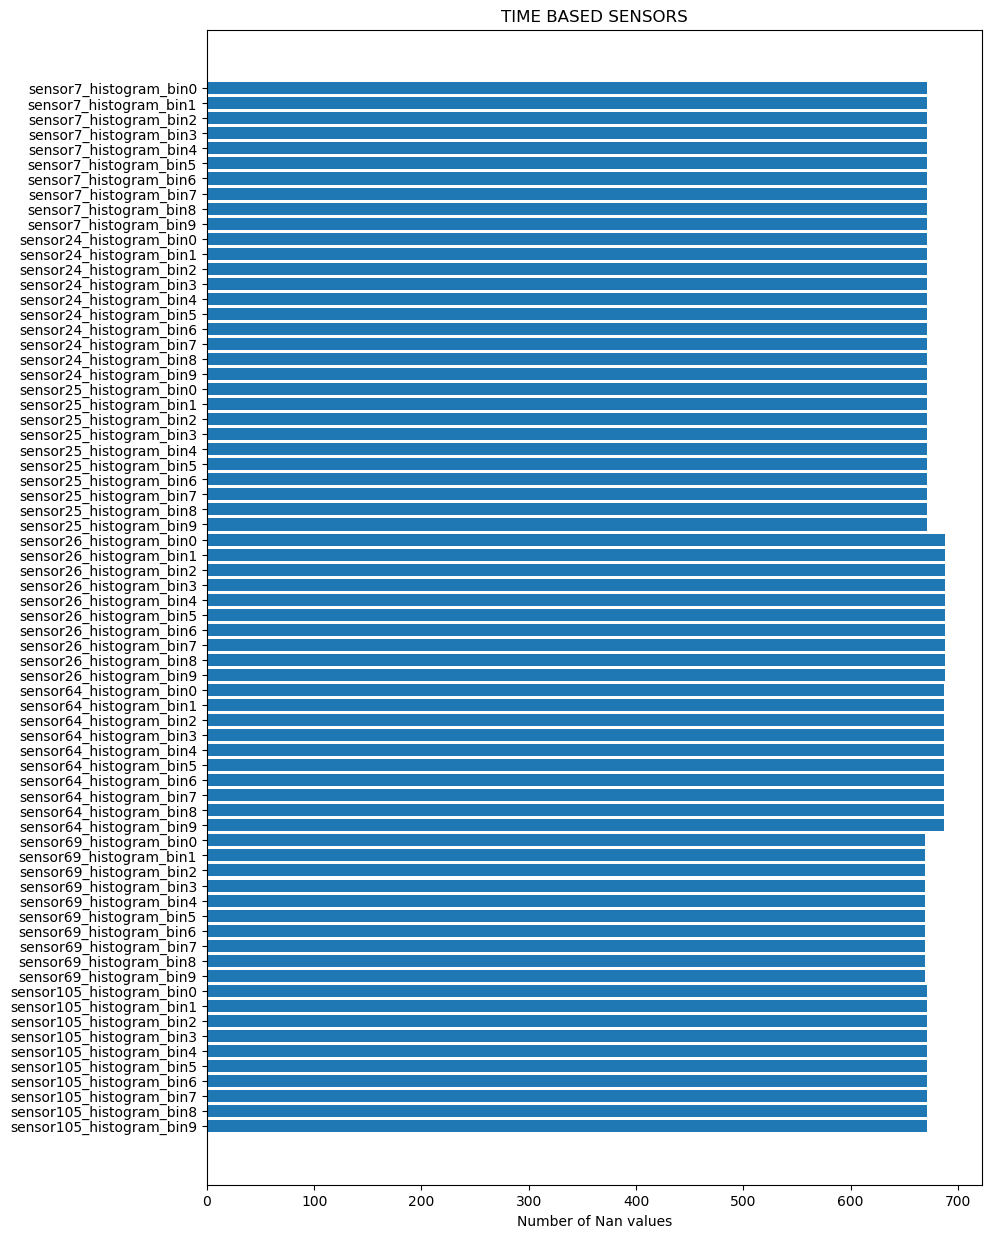

In [ ]:
import numpy as np



plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,15))


y_pos = np.arange(len(sensors))


ax.barh(y_pos, num_of_nan, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(s)
ax.invert_yaxis()  
ax.set_xlabel('Number of Nan values')
ax.set_title('TIME BASED SENSORS')

plt.show()


### Observation:

- It can be observed that for time based sensors the number of NAN values are almost that same for most of the features ,which means that at some rows the reading were not taken .Therefore we can eliminate those rows where we have NAN values.
- There are  671 NAN values in almost all the time based sensor columns.
- None of the features can be removed here.

In [ ]:
num_of_nan=[]
l=[]
s=[]
for i in range(len(column)):
    x=df[column[i]].isna().sum()
    num_of_nan.append(x)
    l.append(i)
    s.append(column[i])
    


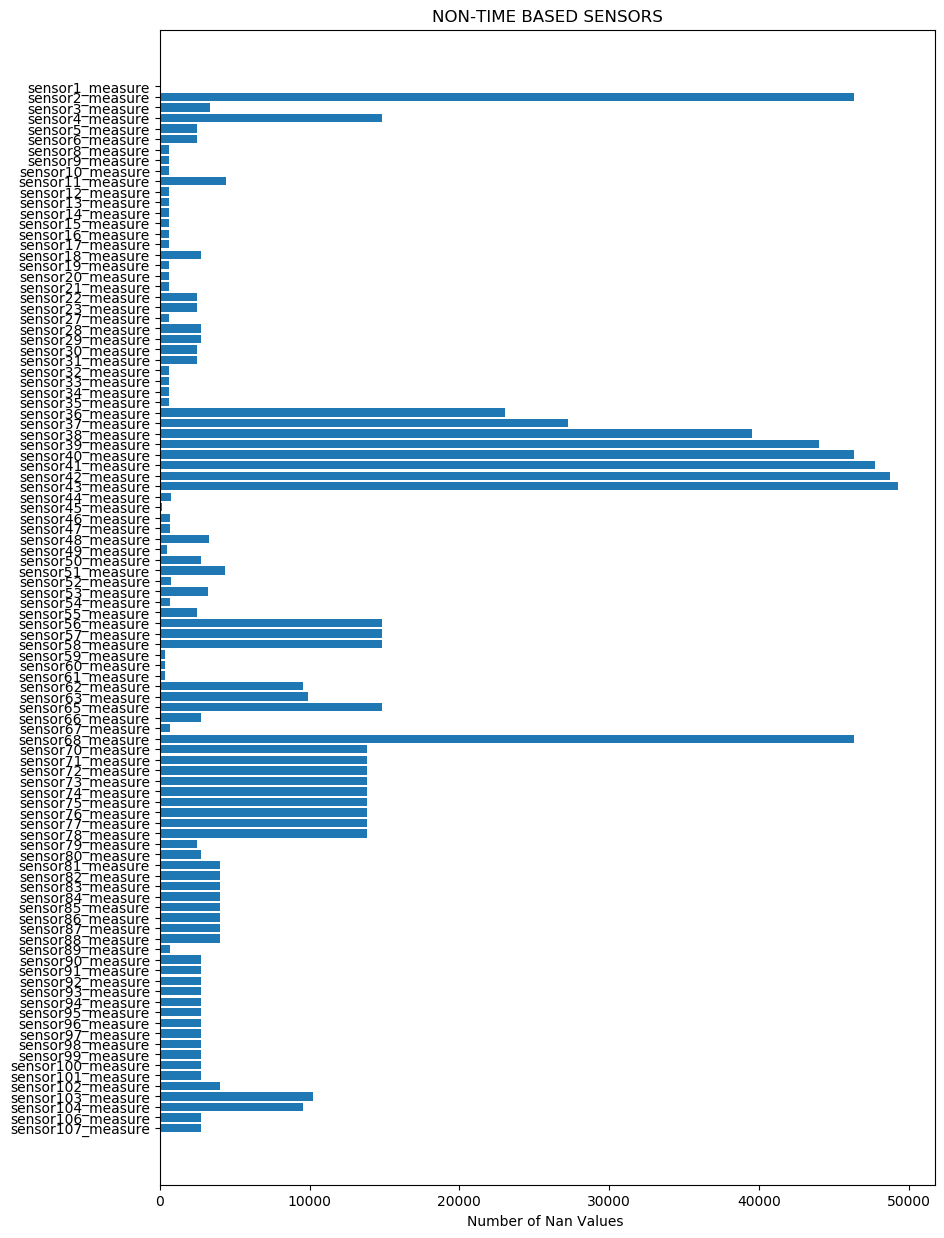

In [ ]:
import numpy as np



plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,15))


y_pos = np.arange(len(column))

ax.barh(y_pos, num_of_nan, align='center',height=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(s)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Nan Values ')
ax.set_title('NON-TIME BASED SENSORS')

plt.show()


## Observations:

- It can be seen that the Nan values in the sensor 1 measure is 0.
- The sensors with most number of Nan values are sensor(38-43) and sensor 2.
- There is no relationship between the number of Nan value and the type of fault.
- We can remove the features with more NAN values .
- We cannot conclude anything substantial from this analysis.


# FINAL EDA CONCLUSION:

### 1) Time-Based Sensors: 
'sensor7_histogram_bin0','sensor7_histogram_bin3','sensor25_histogram_bin2','sensor25_histogram_bin3','sensor25_histogram_bin6', 'sensor25_histogram_bin8','sensor26_histogram_bin1','sensor26_histogram_bin2','sensor26_histogram_bin3','sensor26_histogram_bin4','sensor69_histogram_bin4','sensor69_histogram_bin9' 
#### are important as they are showing spikes for downhole and surface faults with minimum intersection.Out of them 

 sensor 25 bin2,sensor 26 bin1,sensor26 bin2,sensor 26 bin3
 #### are critically important . 


 ### 2) Non_Time Based sensors: The most imoprtant sensors ,with least pdf overlap are :
 sensor8,sensor 17,sensor27,sensor 32,sensor 45 ,sensor46,sensor53

### 3)The sensor 38 to 43 have the most number of NAN values ,which will not add any importance to out data ,therefore we can drop them .

 

## DATA PREPROCESSING:

In [6]:
## will continue once the EDA Is approved
## will normalise the data 
##look for redundant values from the columns.

In [6]:
# As we have found out the columns 36-43 are having many NAN values ,we can remove them .

na_col=['sensor43_measure','sensor42_measure','sensor41_measure','sensor40_measure','sensor68_measure','sensor2_measure','sensor39_measure','sensor38_measure','sensor37_measure','sensor36_measure']
df=df.drop(columns=na_col,axis=1)

In [7]:
Y=df['target']
X=df.drop(['target','id'],axis=1)

In [8]:
# Imputing all the NAN values in columns with the median value
for i in tqdm(X.columns):
  med=X[i].median()
  X[i].fillna(med)

In [9]:
# now we have to normalise the colunms which are more distributed

data=X.values
normalise=MinMaxScaler()
normalise.fit(data)
data=normalise.transform(data)
X= pd.DataFrame(data, columns=X.columns,index=X.index)
X.head(5)

sensor1_measure  sensor3_measure  ...  sensor106_measure  sensor107_measure
0         0.027925     9.999998e-01  ...           0.000000           0.000000
1         0.012036     0.000000e+00  ...           0.000000           0.000000
2         0.014942     1.070067e-07  ...           0.000000           0.000000
3         0.000004     3.285295e-08  ...           0.008299           0.027923
4         0.022164     6.420405e-07  ...           0.000000           0.000000

[5 rows x 160 columns]

In [10]:
## Finding the number of redendunt values in coloumns 
reden=X.nunique().reset_index()
reden.columns=['columns','unique_value']
reden[reden['unique_value']==1]

columns  unique_value
80  sensor54_measure             1

In [11]:
## droping column 54
X=X.drop(['sensor54_measure'],axis=1)

In [12]:
print('The final shape of the dataset is :')
print(X.shape)
print(Y.shape)

The final shape of the dataset is :
(60000, 159)
(60000,)


### Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)


(38400, 159)
(9600, 159)
(12000, 159)
(38400,)
(9600,)
(12000,)


### Using  Oversampling techniques to  data:

In [ ]:
## Using random_sampling
data=X_train[:]
data['target']=y_train
class_0=data[data['target']==0]
class_1=data[data['target']==1]

count_class_0, count_class_1 = data['target'].value_counts()

df_class_1_over =class_1.sample(count_class_0, replace=True)

df_test_over = pd.concat([class_0, df_class_1_over], axis=0)
X_train_random_sample=df_test_over.iloc[:,:-1]
y_train_random_sample=df_test_over['target'] 
print('The total number of points in the the dataset now are {} '.format(X_train_random_sample.shape))
print('The total number of postive/downhole points in the the dataset now are {} '.format(df_test_over['target'].value_counts()[1]))
print('The total number of negative/surface points in the the dataset now are {} '.format(df_test_over['target'].value_counts()[0]))


The total number of points in the the dataset now are (75520, 159) 
The total number of postive/downhole points in the the dataset now are 37760 
The total number of negative/surface points in the the dataset now are 37760 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


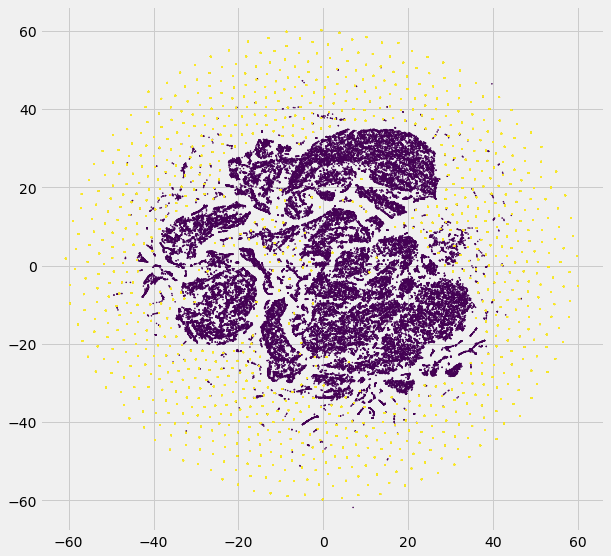

In [ ]:
y_random_sample=df_test_over['target']
X_random_sample=df_test_over.drop(['id','target'],axis=1)
x_data = X_random_sample
y_data = y_random_sample
y_data=np.array(y_data)
x_data  = x_data .fillna(x_data .median())
#n = 20000
#x_data = x_data[:n]
#y_data = y_data[:n]

tsne = TSNE(n_components=2,verbose=0, random_state=0)
transformed_data = tsne.fit_transform(x_data)
k = np.array(transformed_data)
plt.figure(figsize=(9,9))
plt.scatter(k[:, 0], k[:, 1], c=y_data, zorder=10, s=1)
plt.show()

### Observation

- It can be observed here that by random sampling ,we are obtaining oversampled points on the outer circle ,alloted randomly.
- This is not good for classification task as  many points can be misscalassified.

## 2. SMOTE

In [15]:
from imblearn.over_sampling import SMOTE

#y=df['target']
#x=df.drop(['target','id'],axis=1)
x = X_train.fillna(X_train.median())
smote = SMOTE(sampling_strategy=0.1, random_state = 32)
X_SMOTE, y_SMOTE = smote.fit_sample(x, y_train)
(unique, counts)=np.unique(y_SMOTE, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('The shape of the data is now:',X_SMOTE.shape)
print('The number of downhole fault are:',frequencies[1][1])
print('The number of surface fault are:',frequencies[0][1])

The shape of the data is now: (41536, 159)
The number of downhole fault are: 3776
The number of surface fault are: 37760


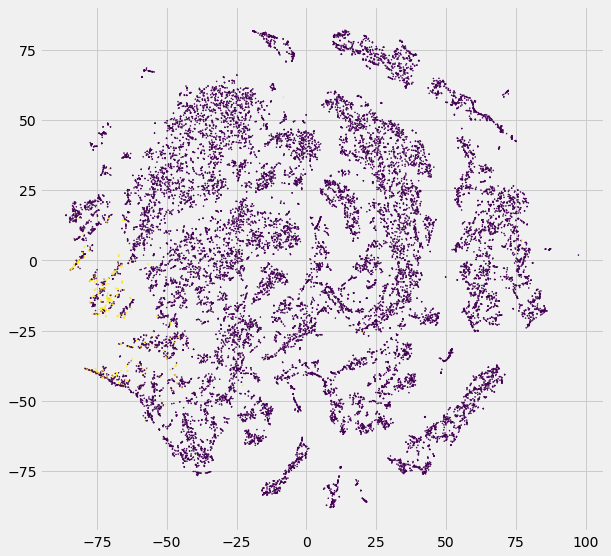

In [ ]:
from sklearn.manifold import TSNE

x_data = X_SMOTE
y_data = y_SMOTE

n = 20000
x_data = x_data[:n]
y_data = y_data[:n]

tsne = TSNE(n_components=2,verbose=0, random_state=0)
transformed_data = tsne.fit_transform(x_data)
k = np.array(transformed_data)
plt.figure(figsize=(9,9))
plt.scatter(k[:, 0], k[:, 1], c=y_data, zorder=10, s=1)
plt.show()

### Observation:

-With SMOTE oversampling ,it can be  seen a clustered yellow minority yellow points .

## 3. ADASYN

In [ ]:
#implementing Adaptive synthethic sampling 
#https://towardsdatascience.com/adasyn-adaptive-synthetic-sampling-method-for-imbalanced-data-602a3673ba16
from collections import Counter
x = X.fillna(X.median())
ada=ADASYN(sampling_strategy='minority', random_state=420 ,n_neighbors=5)
X_ada,Y_ada=ada.fit_resample(x,Y)

print('Oversampled distribution after Adaptive synthetic sampling',Counter(Y_ada))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Oversampled distribution after Adaptive synthetic sampling Counter({1: 59077, 0: 59000})


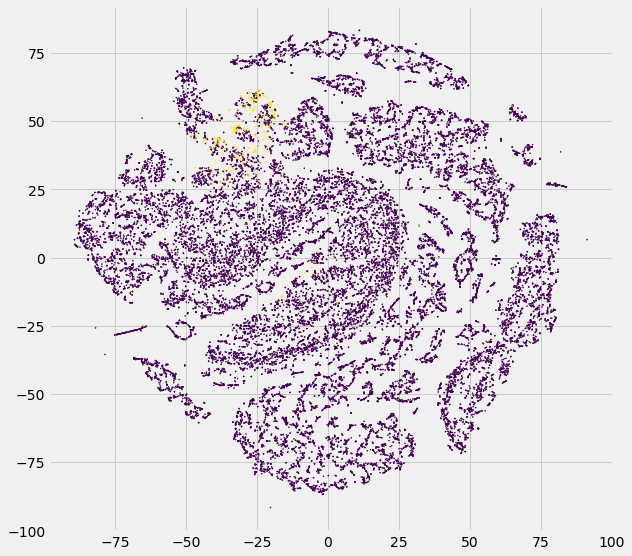

In [ ]:
from sklearn.manifold import TSNE

x_data = X_ada
y_data = Y_ada

n = 30000
x_data = x_data[:n]
y_data = y_data[:n]

tsne = TSNE(n_components=2,verbose=0, random_state=0,perplexity=20)
transformed_data = tsne.fit_transform(x_data)
k = np.array(transformed_data)
plt.figure(figsize=(9,9))
plt.scatter(k[:, 0], k[:, 1], c=y_data, zorder=10, s=1)
plt.show()

### Observation:
- It can be observed that a overlapping cluster is formed of the minority points .
- The overlap is not good for classification but ,features can be extracted with feature engineering.
- This is performing better than random oversampling .

## 4. Boderline SMOTE

In [ ]:
#Appling boderline SMOTE
from collections import Counter
x = X_train.fillna(X_train.median())
oversample = BorderlineSMOTE()
X_boderline_smote, y_boderline_smote = oversample.fit_resample(x, y_train)
print('Oversampled distribution after Adaptive synthetic sampling',Counter(y_boderline_smote))

Oversampled distribution after Adaptive synthetic sampling Counter({0: 37760, 1: 37760})


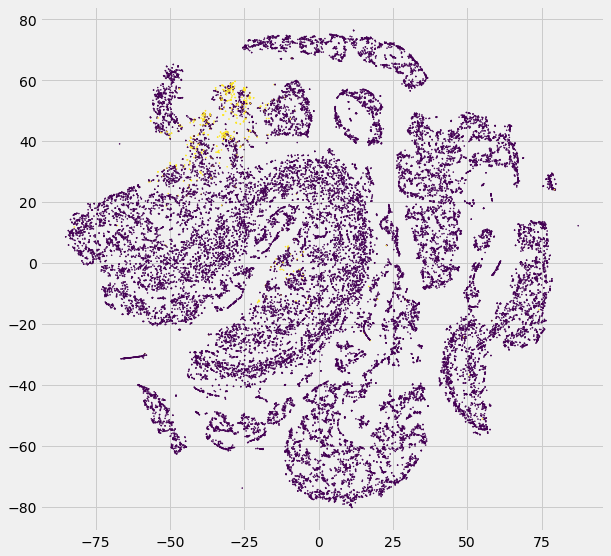

In [ ]:
from sklearn.manifold import TSNE

x_data = X_boderline_smote
y_data = y_boderline_smote
n = 30000
x_data = x_data[:n]
y_data = y_data[:n]

tsne = TSNE(n_components=2,verbose=0, random_state=0,perplexity=30)
transformed_data = tsne.fit_transform(x_data)
k = np.array(transformed_data)
plt.figure(figsize=(9,9))
plt.scatter(k[:, 0], k[:, 1], c=y_data, zorder=10, s=1)
plt.show()

### Observation:
- It can be seen that many clusters of yellow have been fond using boderline SMOTE .
- This is better than random oversampling ,but we have to verify its performance by feature engineering and using it in a model.

## Implemention of Logistic regression on all the above oversampled models:

###  Defining the F1 score function:

In [16]:
## writing the defination of F1 score

def F1_score(Y_actual,Y_pred):
  precision=precision_score(Y_actual,Y_pred)
  recall=recall_score(Y_actual,Y_pred)
  f1_score=(2*((precision*recall)/(precision+recall)))
  return f1_score


### 1. Logistic Regression on Random Oversampling:

In [ ]:
import timeit

% timeit

X_train_random_sample=X_train_random_sample.fillna(X_train_random_sample.median())
lr_model=LogisticRegression( random_state =32,penalty='l2')
model_params ={'C':([0.001,0.01,0.1,1,10,100,1000])}
clf = RandomizedSearchCV(lr_model, model_params, cv=10, random_state=1,verbose=1)
model=clf.fit(X_train_random_sample,y_train_random_sample)
print(model.best_estimator_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  2.0min finished


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=32, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
lr_model=LogisticRegression( C=1000,random_state =32,penalty='l2')
lr_model.fit(X_train_random_sample,y_train_random_sample)

X_cv=X_cv.fillna(X_cv.median())
X_test=X_test.fillna(X_test.median())

predict_y_train = lr_model.predict(X_train_random_sample)
predict_y_cv = lr_model.predict(X_cv)
predict_y_test = lr_model.predict(X_test)

print(F1_score(y_train_random_sample,predict_y_train))
print(F1_score(y_cv,predict_y_cv))
print(F1_score(y_test,predict_y_test))



0.9636232039459575
0.5565862708719852
0.5610859728506787


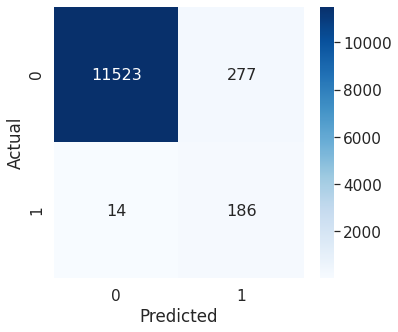

In [ ]:

# kaggle.com/agungor2/various-confusion-matrix-plots
data = confusion_matrix(y_test, predict_y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


### 2. Logistic Regression on SMOTE Oversampling:

In [ ]:
% timeit

lr_model=LogisticRegression( random_state =32,penalty='l2')
model_params ={'C':([0.001,0.01,0.1,1,10,100,1000])}
clf = RandomizedSearchCV(lr_model, model_params, cv=10, random_state=1,verbose=1)
model=clf.fit(X_SMOTE,y_SMOTE)
print(model.best_estimator_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   54.4s finished


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=32, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
lr_model=LogisticRegression( C=1000,random_state =32,penalty='l2')
lr_model.fit(X_SMOTE,y_SMOTE)

X_cv=X_cv.fillna(X_cv.median())
X_test=X_test.fillna(X_test.median())

predict_y_train = lr_model.predict(X_SMOTE)
predict_y_cv = lr_model.predict(X_cv)
predict_y_test = lr_model.predict(X_test)

print('The F1 score for Train Set is :',F1_score(y_SMOTE,predict_y_train))
print('The F1 score for CV Set is :',F1_score(y_cv,predict_y_cv))
print('The F1 score for Test Set is: ',F1_score(y_test,predict_y_test))

The F1 score for Train Set is : 0.8867403314917127
The F1 score for CV Set is : 0.6896551724137931
The F1 score for Test Set is:  0.7042889390519187


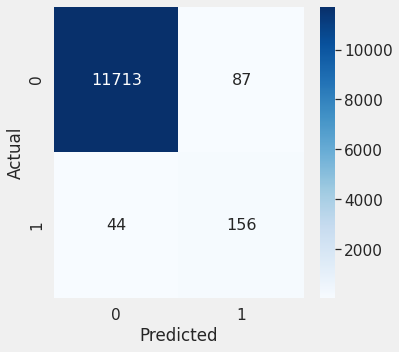

In [ ]:
data = confusion_matrix(y_test, predict_y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


### 3. Logistic Regression on ADADYN Oversampling :

In [ ]:

lr_model=LogisticRegression( random_state =32,penalty='l2')
model_params ={'C':([0.001,0.01,0.1,1,10,100,1000])}
clf = RandomizedSearchCV(lr_model, model_params, n_iter=100, cv=10, random_state=1,verbose=1)
model=clf.fit(X_ada,Y_ada)
print(model.best_estimator_)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  3.3min finished


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=32, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
lr_model=LogisticRegression( C=1000,random_state =32,penalty='l2')
lr_model.fit(X_ada,Y_ada)

X_cv=X_cv.fillna(X_cv.median())
X_test=X_test.fillna(X_test.median())

predict_y_train = lr_model.predict(X_ada)
predict_y_cv = lr_model.predict(X_cv)
predict_y_test = lr_model.predict(X_test)

print('The F1 score for Train Set is :',F1_score( Y_ada,predict_y_train))
print('The F1 score for CV Set is :',F1_score(y_cv,predict_y_cv))
print('The F1 score for Test Set is: ',F1_score(y_test,predict_y_test))

The F1 score for Train Set is : 0.949400212451745
The F1 score for CV Set is : 0.5040916530278232
The F1 score for Test Set is:  0.5267489711934157


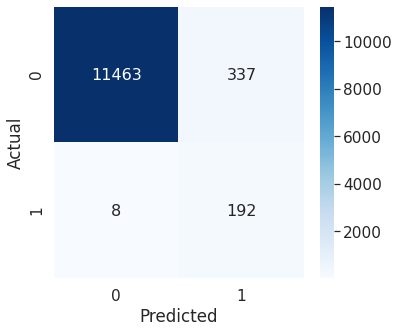

In [ ]:
data = confusion_matrix(y_test, predict_y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


### 4. Logistic Regression on Boderline SMOTE:

In [ ]:
lr_model=LogisticRegression( random_state =32,penalty='l2')
model_params ={'C':([0.001,0.01,0.1,1,10,100,1000])}
clf = RandomizedSearchCV(lr_model, model_params, n_iter=100, cv=10, random_state=1,verbose=1)
model=clf.fit(X_boderline_smote, y_boderline_smote)
print(model.best_estimator_)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  3.2min finished


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=32, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
lr_model=LogisticRegression( C=1000,random_state =32,penalty='l2')
lr_model.fit(X_boderline_smote, y_boderline_smote)

X_cv=X_cv.fillna(X_cv.median())
X_test=X_test.fillna(X_test.median())

predict_y_train = lr_model.predict(X_boderline_smote)
predict_y_cv = lr_model.predict(X_cv)
predict_y_test = lr_model.predict(X_test)

print('The F1 score for Train Set is :',F1_score( y_boderline_smote,predict_y_train))
print('The F1 score for CV Set is :',F1_score(y_cv,predict_y_cv))
print('The F1 score for Test Set is: ',F1_score(y_test,predict_y_test))

The F1 score for Train Set is : 0.9746309225603581
The F1 score for CV Set is : 0.5916666666666667
The F1 score for Test Set is:  0.5919732441471572


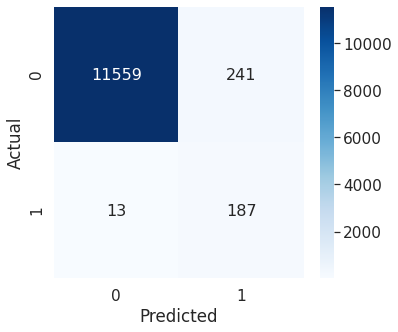

In [ ]:
data = confusion_matrix(y_test, predict_y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


In [ ]:
table=[['Randomly Oversampled',0.9636232039459575,0.5565862708719852,0.5610859728506787],['SMOTE Oversampled',0.8722246990637539,0.7213,0.7427],
       ['Adaptive_Synthetic Oversampling',0.949,0.5040,0.5267],['Boderline_SMOTE',0.9738,0.596,0.595]]

print(tabulate(table, tablefmt='orgtbl',headers=["Oversampling Type","Train F1-score", "CV F1-score",'Test F1-score']))


| Oversampling Type               |   Train F1-score |   CV F1-score |   Test F1-score |
|---------------------------------+------------------+---------------+-----------------|
| Randomly Oversampled            |         0.963623 |      0.556586 |        0.561086 |
| SMOTE Oversampled               |         0.872225 |      0.7213   |        0.7427   |
| Adaptive_Synthetic Oversampling |         0.949    |      0.504    |        0.5267   |
| Boderline_SMOTE                 |         0.9738   |      0.596    |        0.595    |


### Observation:
- 1) It can been seen that SMOTE oversampling is best suited for our data set .
- 2) The F1 score for the train data is the most for the Boderline SMOTE .This means that cluster formation is leading to overfit of the data . 
- 3)We can see the confusion matrix for randomly sampled data and adaptive synthetic arent very precise ,as they are misclassifying many points .
- 4 We can conclude from this that SMOTE Oversampling can give good results to our data.

## Random Forest Classifer :

### Applying Random Forest Classifier with HyperParameter Tuning on SMOTE oversampled data:

In [ ]:
# we will now use SMOTE oversampled data for finding the best Hyperparameter for Random Forest model


rf_model = RandomForestClassifier(random_state=32,n_jobs=-1)
model_params ={'n_estimators':([10,20,50,100,200])}
clf = GridSearchCV(rf_model, model_params,cv=10,verbose=1)
model=clf.fit(X_SMOTE, y_SMOTE)
print(model.best_estimator_)



Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 27.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)


In [ ]:
# The best hyperparameter is 100.

rf_model = RandomForestClassifier(n_estimators=100,random_state=32,n_jobs=-1)
rf_model.fit(X_SMOTE, y_SMOTE)


predict_y_train = rf_model .predict(X_SMOTE)
predict_y_cv = rf_model.predict(X_cv)
predict_y_test = rf_model.predict(X_test)

print('The F1 score for Train Set is :',F1_score( y_SMOTE,predict_y_train))
print('The F1 score for CV Set is :',F1_score(y_cv,predict_y_cv))
print('The F1 score for Test Set is: ',F1_score(y_test,predict_y_test))

The F1 score for Train Set is : 1.0
The F1 score for CV Set is : 0.7697160883280757
The F1 score for Test Set is:  0.7989949748743719


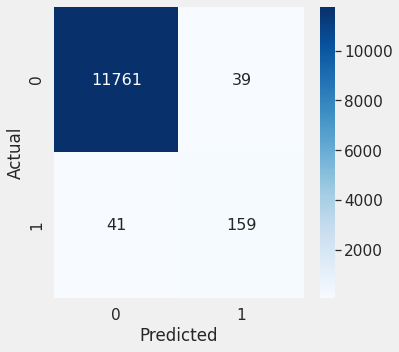

In [ ]:
data = confusion_matrix(y_test, predict_y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


### The Top 10 Important features using Random forest.

In [ ]:
names=X_train.columns
print (sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), names), 
             reverse=True)[0:10])

[(0.0492, 'sensor35_measure'), (0.0405, 'sensor46_measure'), (0.0403, 'sensor17_measure'), (0.04, 'sensor89_measure'), (0.0361, 'sensor16_measure'), (0.0359, 'sensor32_measure'), (0.0332, 'sensor67_measure'), (0.0332, 'sensor27_measure'), (0.0331, 'sensor1_measure'), (0.0271, 'sensor53_measure')]


### Observations:
- It can be seen that random forest alone gives us a decent result by misclassifying less than 1% of the total test data.(i.e 0.66% data misclassified ).Which means it has a accuracy of 99 %.
- Also we can see that random forest is not able to use the time based sensors ,and therefore time based sensors are of no use for random forest.
- We have also obtained the important features used by the random forest ,from which we can see that sensor 35 measure ,sensor46 measure  and sensor 17 measure are the top 3 features.


## XGBOOST Classifier:

### Using Xgboost with HyperParameter Tuning on the SMOTE Oversampled Data :

In [ ]:
estimator=[10,50,100,500,1000]
score=[]
for i in tqdm(estimator):
  xgb = XGBClassifier(n_estimators=i,nthread=-1,random_state = 32)
  xgb.fit(X_SMOTE, y_SMOTE)
  predict_y_cv = xgb.predict(X_cv)
  score.append(F1_score(y_cv,predict_y_cv))

res = dict(zip(estimators, score)) 


In [ ]:
print('The hyperparameter is :',max(res, key=res.get))

The hyperparameter is : 1000


In [ ]:
score

[0.585,
 0.6701570680628272,
 0.751412429378531,
 0.9473684210526315,
 0.9968652037617556]

- The hyper parameter with the highest F1 score is 1000.(i.e 0.9968)

In [ ]:
xgb = XGBClassifier(n_estimators=1000,nthread=-1,random_state = 32)
xgb.fit(X_SMOTE, y_SMOTE)

predict_y_train = xgb.predict(X_SMOTE)
predict_y_cv = xgb.predict(X_cv)
predict_y_test = xgb.predict(X_test)

print('The F1 score for Train Set is :',F1_score( y_SMOTE,predict_y_train))
print('The F1 score for CV Set is :',F1_score(y_cv,predict_y_cv))
print('The F1 score for Test Set is: ',F1_score(y_test,predict_y_test))
print('The accuracy score for Test data:',accuracy_score(y_test, predict_y_test))

The F1 score for Train Set is : 1.0
The F1 score for CV Set is : 0.821656050955414
The F1 score for Test Set is:  0.8082901554404146
The accuracy score for Test data: 0.9938333333333333


In [ ]:
X_SMOTE=pd.DataFrame(X_SMOTE,columns=X_train.columns)

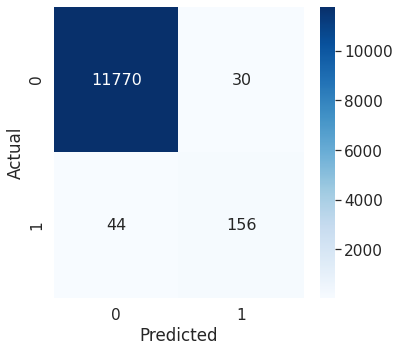

In [ ]:
data = confusion_matrix(y_test, predict_y_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


## Top 15 Features using Xgboost:

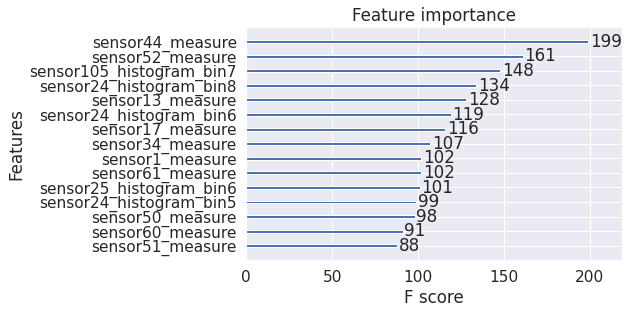

In [ ]:
plot_importance(xgb,max_num_features=15)
plt.show()

### Observation:

- It can be seen that we are getting out best result so far using Xgboost model ,with a test F1 score of 0.80 .
- The accuracy we achieve is very close to the accuracy with random forest i.e 99.38% ,but the F1 score is significantly better than the random forest model.
- The number of misclassified points are 73 i.e 7 less misclassfied points than random forest model.
- We can see that sensor 44 measure,sensor52 measure and sensor 17 become the most important feautures for our dataset as they  are the same for Xgboost as well as Random Forest.
- We can observe that some of the time based features are also providing good information for classification,unlike the case of random forest.
- Most of the top 15 features are non time based features.This means that time features can be used efficiently by the regular Machine Learning models.Therefore we have to experiment with Deep Learning Techniques especially for time based features.

# Deep Learning :

##  LSTM model on the time based sensors :
## Simple Neural Net on the non time based sensors:

### Preparing the data for LSTM input



In [17]:
col_sen_7 = ['sensor7_histogram_bin0','sensor7_histogram_bin1','sensor7_histogram_bin2','sensor7_histogram_bin3',
             'sensor7_histogram_bin4','sensor7_histogram_bin5','sensor7_histogram_bin6', 'sensor7_histogram_bin7',
             'sensor7_histogram_bin8','sensor7_histogram_bin9']
col_sen_24 = ['sensor24_histogram_bin0','sensor24_histogram_bin1','sensor24_histogram_bin2','sensor24_histogram_bin3',
             'sensor24_histogram_bin4','sensor24_histogram_bin5','sensor24_histogram_bin6', 'sensor24_histogram_bin7',
             'sensor24_histogram_bin8','sensor24_histogram_bin9']
col_sen_25 = ['sensor25_histogram_bin0','sensor25_histogram_bin1','sensor25_histogram_bin2','sensor25_histogram_bin3',
             'sensor25_histogram_bin4','sensor25_histogram_bin5','sensor25_histogram_bin6', 'sensor25_histogram_bin7',
             'sensor25_histogram_bin8','sensor25_histogram_bin9']
col_sen_26 = ['sensor26_histogram_bin0','sensor26_histogram_bin1','sensor26_histogram_bin2','sensor26_histogram_bin3',
             'sensor26_histogram_bin4','sensor26_histogram_bin5','sensor26_histogram_bin6', 'sensor26_histogram_bin7',
             'sensor26_histogram_bin8','sensor26_histogram_bin9']
col_sen_64 = ['sensor64_histogram_bin0','sensor64_histogram_bin1','sensor64_histogram_bin2','sensor64_histogram_bin3',
             'sensor64_histogram_bin4','sensor64_histogram_bin5','sensor64_histogram_bin6', 'sensor64_histogram_bin7',
             'sensor64_histogram_bin8','sensor64_histogram_bin9']
col_sen_69 = ['sensor69_histogram_bin0','sensor69_histogram_bin1','sensor69_histogram_bin2','sensor69_histogram_bin3',
             'sensor69_histogram_bin4','sensor69_histogram_bin5','sensor69_histogram_bin6', 'sensor69_histogram_bin7',
             'sensor69_histogram_bin8','sensor69_histogram_bin9']
col_sen_105 = ['sensor105_histogram_bin0','sensor105_histogram_bin1','sensor105_histogram_bin2','sensor105_histogram_bin3',
             'sensor105_histogram_bin4','sensor105_histogram_bin5','sensor105_histogram_bin6', 'sensor105_histogram_bin7',
             'sensor105_histogram_bin8','sensor105_histogram_bin9']
             


### Convert our data such that we have 7*10 Input at each time stamp:


In [20]:
## Preparing the x_cv and x_test in the same way
#X_SMOTE=pd.DataFrame(X_SMOTE,columns=X_cv.columns)
X_train_time=X_SMOTE[sensors]
X_cv_time=X_cv[sensors]
X_test_time=X_test[sensors]





In [21]:
sensor7_train=X_train_time[col_sen_7]
sensor24_train=X_train_time[col_sen_24]
sensor25_train=X_train_time[col_sen_25]
sensor26_train=X_train_time[col_sen_26]
sensor64_train=X_train_time[col_sen_64]
sensor69_train=X_train_time[col_sen_69]
sensor105_train=X_train_time[col_sen_105]


sensor7_cv=X_cv_time[col_sen_7]
sensor24_cv=X_cv_time[col_sen_24]
sensor25_cv=X_cv_time[col_sen_25]
sensor26_cv=X_cv_time[col_sen_26]
sensor64_cv=X_cv_time[col_sen_64]
sensor69_cv=X_cv_time[col_sen_69]
sensor105_cv=X_cv_time[col_sen_105]

sensor7_test=X_test_time[col_sen_7]
sensor24_test=X_test_time[col_sen_24]
sensor25_test=X_test_time[col_sen_25]
sensor26_test=X_test_time[col_sen_26]
sensor64_test=X_test_time[col_sen_64]
sensor69_test=X_test_time[col_sen_69]
sensor105_test=X_test_time[col_sen_105]




In [22]:
X_train_LSTM=[]
for i in tqdm(range (len(X_train_time))):
  input_at_one_time=[]
  input_at_one_time.append(sensor7_train.values[i])
  input_at_one_time.append(sensor24_train.values[i])
  input_at_one_time.append(sensor25_train.values[i])
  input_at_one_time.append(sensor26_train.values[i])
  input_at_one_time.append(sensor64_train.values[i])
  input_at_one_time.append(sensor69_train.values[i])
  input_at_one_time.append(sensor105_train.values[i])
  X_train_LSTM.append(input_at_one_time)

X_train_LSTM=np.array(X_train_LSTM)
X_train_LSTM.shape

(41536, 7, 10)

In [23]:
X_cv_LSTM=[]
for i in tqdm(range (len(X_cv_time))):
  input_at_one_time=[]
  input_at_one_time.append(sensor7_cv.values[i])
  input_at_one_time.append(sensor24_cv.values[i])
  input_at_one_time.append(sensor25_cv.values[i])
  input_at_one_time.append(sensor26_cv.values[i])
  input_at_one_time.append(sensor64_cv.values[i])
  input_at_one_time.append(sensor69_cv.values[i])
  input_at_one_time.append(sensor105_cv.values[i])
  X_cv_LSTM.append(input_at_one_time)

X_cv_LSTM=np.array(X_cv_LSTM)
X_cv_LSTM.shape

(9600, 7, 10)

In [24]:
X_test_LSTM=[]
for i in tqdm(range (len(X_test_time))):
  input_at_one_time=[]
  input_at_one_time.append(sensor7_test.values[i])
  input_at_one_time.append(sensor24_test.values[i])
  input_at_one_time.append(sensor25_test.values[i])
  input_at_one_time.append(sensor26_test.values[i])
  input_at_one_time.append(sensor64_test.values[i])
  input_at_one_time.append(sensor69_test.values[i])
  input_at_one_time.append(sensor105_test.values[i])
  X_test_LSTM.append(input_at_one_time)

X_test_LSTM=np.array(X_test_LSTM)
X_test_LSTM.shape

(12000, 7, 10)

### The shapes of time based sensors input :

In [25]:
X_train_LSTM_input=tf.convert_to_tensor(X_train_LSTM, dtype=tf.float32)
X_cv_LSTM_input=tf.convert_to_tensor(X_cv_LSTM, dtype=tf.float32)
X_test_LSTM_input=tf.convert_to_tensor(X_test_LSTM, dtype=tf.float32)

print('The input shape of the train data is :',X_train_LSTM_input.shape)
print('The input shape of the cv data is :',X_cv_LSTM_input.shape)
print('The input shape of the test data is :',X_test_LSTM_input.shape)

The input shape of the train data is : (41536, 7, 10)
The input shape of the cv data is : (9600, 7, 10)
The input shape of the test data is : (12000, 7, 10)


In [26]:
#convert the y data into categorical form
y_smote = to_categorical(y_SMOTE)
y_cv_2= to_categorical(y_cv)

### The shape of Non Time based sensors input :

In [27]:
# Preparing the Non Time based sensors:

X_train_non_time_sensors=X_SMOTE.drop(sensors,axis=1)
X_cv_non_time_sensors=X_cv.drop(sensors,axis=1)
X_test_non_time_sensors=X_test.drop(sensors,axis=1)

print(X_train_non_time_sensors.shape)
print(X_cv_non_time_sensors.shape)
print(X_test_non_time_sensors.shape)

(41536, 89)
(9600, 89)
(12000, 89)


## LSTM Model for time based Inputs:

In [28]:


input_lstm = tf.keras.layers.Input(shape=(7,10))
l = tf.keras.layers.LSTM(100) (input_lstm)
l = tf.keras.layers.Flatten() (l)
l = tf.keras.layers.Dense(16,activation='relu') (l)
l = tf.keras.layers.Dropout(0.4) (l)
l = tf.keras.layers.Dense(8,activation='relu') (l)

lstm_output = tf.keras.layers.Dense(2,activation='softmax') (l)

lstm_model = Model(inputs=input_lstm,outputs= lstm_output)

print(lstm_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 10)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [29]:
epoch = 20
batch_size = 64


lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',
                      metrics=[tfa.metrics.F1Score(num_classes=2, average="micro")])
lstm_model.fit(X_train_LSTM_input, y_smote,
                  batch_size=batch_size,
                  validation_data=(X_cv_LSTM_input,y_cv_2),
                  
                  epochs=epoch,
                  verbose=1)

Epoch 1/20
649/649 [==============================] - 5s 8ms/step - loss: 0.1743 - f1_score: 0.9467 - val_loss: 0.1020 - val_f1_score: 0.9604
Epoch 2/20
649/649 [==============================] - 4s 7ms/step - loss: 0.1422 - f1_score: 0.9508 - val_loss: 0.0906 - val_f1_score: 0.9732
Epoch 3/20
649/649 [==============================] - 4s 7ms/step - loss: 0.1374 - f1_score: 0.9513 - val_loss: 0.0952 - val_f1_score: 0.9706
Epoch 4/20
649/649 [==============================] - 4s 7ms/step - loss: 0.1333 - f1_score: 0.9521 - val_loss: 0.0841 - val_f1_score: 0.9710
Epoch 5/20
649/649 [==============================] - 4s 7ms/step - loss: 0.1268 - f1_score: 0.9557 - val_loss: 0.0811 - val_f1_score: 0.9800
Epoch 6/20
649/649 [==============================] - 4s 7ms/step - loss: 0.1204 - f1_score: 0.9609 - val_loss: 0.0852 - val_f1_score: 0.9719
Epoch 7/20
649/649 [==============================] - 4s 7ms/step - loss: 0.1174 - f1_score: 0.9617 - val_loss: 0.0935 - val_f1_score: 0.9836
Epoch 

### Observation:

- It can be seen that by only using the time based features ,we are able to achieve a f1 score of 0.98 ,which is very good.
- No case of ovefitting is obeserved here, and therefore the outputs of this model can be used as an ensemble with other models.

In [30]:
#the outputs that we got from LSTM
lstm_train_output = lstm_model.predict(X_train_LSTM_input)
lstm_cv_output = lstm_model.predict(X_cv_LSTM_input)
lstm_test_output = lstm_model.predict(X_test_LSTM_input)

### Constructing a simple Neural Net for Non time based data:

In [31]:

from keras.models import Sequential
from keras.layers import Activation, Dense,Dropout,Flatten



model = Sequential()
model.add(Dense(64, input_dim=89, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy',optimizer='adam',
                      metrics=[tfa.metrics.F1Score(num_classes=2, average="micro")])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                5760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1

In [32]:
epoch = 5
batch_size = 64


model.fit(X_train_non_time_sensors, y_smote,
                  batch_size=batch_size,
                  validation_data=(X_cv_non_time_sensors, y_cv_2),
                  
                  epochs=epoch,
                  verbose=1)

Epoch 1/5
649/649 [==============================] - 3s 5ms/step - loss: 0.1627 - f1_score: 0.9477 - val_loss: 0.0863 - val_f1_score: 0.9790
Epoch 2/5
649/649 [==============================] - 3s 4ms/step - loss: 0.0939 - f1_score: 0.9647 - val_loss: 0.0818 - val_f1_score: 0.9811
Epoch 3/5
649/649 [==============================] - 3s 4ms/step - loss: 0.0823 - f1_score: 0.9699 - val_loss: 0.0764 - val_f1_score: 0.9820
Epoch 4/5
649/649 [==============================] - 3s 4ms/step - loss: 0.0751 - f1_score: 0.9727 - val_loss: 0.0764 - val_f1_score: 0.9830
Epoch 5/5
649/649 [==============================] - 3s 4ms/step - loss: 0.0707 - f1_score: 0.9737 - val_loss: 0.0817 - val_f1_score: 0.9818


### Observations:

- It can be seen that we get train F1 score of 0.98 and test score is 0.98 ,using a very simple dense network and only using the time based sensors.
- We can combine the results of the LSTM and this dense network by using their outputs in another dense network .

In [33]:
dense_train_output = model.predict(X_train_non_time_sensors)
dense_cv_output = model.predict(X_cv_non_time_sensors)
dense_test_output = model.predict(X_test_non_time_sensors)

In [34]:
temp1 = pd.DataFrame(lstm_train_output, columns=['dynamic_f1','dynamic_f2'])
temp2 = pd.DataFrame(dense_train_output, columns=['static_f1','static_f2'])
train_stage2 = pd.concat([temp1, temp2], axis=1)
train_stage2.head(2)


temp1 = pd.DataFrame(lstm_cv_output, columns=['dynamic_f1','dynamic_f2'])
temp2 = pd.DataFrame(dense_cv_output, columns=['static_f1','static_f2'])
cv_stage2 = pd.concat([temp1, temp2], axis=1)

temp1 = pd.DataFrame(lstm_test_output, columns=['dynamic_f1','dynamic_f2'])
temp2 = pd.DataFrame(dense_test_output, columns=['static_f1','static_f2'])
test_stage2 = pd.concat([temp1, temp2], axis=1)

## Final Dense  Neural Network  for combined features of LSTM and Dense network:

In [35]:
model_final = Sequential()
model_final.add(Dense(128, input_dim=4, activation='relu'))
model_final.add(Dropout(0.4))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.4))
model_final.add(Dense(32, activation='relu'))
model_final.add(Dense(8, activation='relu'))
model_final.add(Flatten())

model_final.add(Dense(2,activation='softmax'))

print(model_final.summary())
model_final.compile(loss='categorical_crossentropy',optimizer='adam',
                      metrics=[tfa.metrics.F1Score(num_classes=2, average="micro")])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               640       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                

In [36]:
epoch = 10
batch_size = 64


model_final.fit(train_stage2, y_smote,
                  batch_size=batch_size,
                  validation_data=(cv_stage2, y_cv_2),
                  
                  epochs=epoch,
                  verbose=1)

Epoch 1/10
649/649 [==============================] - 3s 5ms/step - loss: 0.0785 - f1_score: 0.9729 - val_loss: 0.0416 - val_f1_score: 0.9831
Epoch 2/10
649/649 [==============================] - 3s 4ms/step - loss: 0.0597 - f1_score: 0.9796 - val_loss: 0.0380 - val_f1_score: 0.9845
Epoch 3/10
649/649 [==============================] - 3s 4ms/step - loss: 0.0582 - f1_score: 0.9800 - val_loss: 0.0441 - val_f1_score: 0.9845
Epoch 4/10
649/649 [==============================] - 3s 4ms/step - loss: 0.0580 - f1_score: 0.9794 - val_loss: 0.0431 - val_f1_score: 0.9844
Epoch 5/10
649/649 [==============================] - 3s 5ms/step - loss: 0.0572 - f1_score: 0.9803 - val_loss: 0.0408 - val_f1_score: 0.9845
Epoch 6/10
649/649 [==============================] - 3s 5ms/step - loss: 0.0570 - f1_score: 0.9800 - val_loss: 0.0375 - val_f1_score: 0.9864
Epoch 7/10
649/649 [==============================] - 3s 5ms/step - loss: 0.0567 - f1_score: 0.9805 - val_loss: 0.0362 - val_f1_score: 0.9872
Epoch 

### Observation:

- We can observe that we ,achieve a F1 score of 0.9901 for the data set .
- We can therefore conclude that using our deep learning model with a combination of LSTM and dense networks we can achieve better F1 score.In this case the MLP is extracting the best feautures automatically by itself therefore we obtain this results.
- We can see that the Xgboost model gives us a test data F1 score of 0.80 ,and random forest gives us a score of  0.72 ,therefore compared to the Machine Learning models ,the deep learning models are performing more accurately.

In [47]:
import pickle 
from keras.models import load_model



lstm_model.save('/content/drive/My Drive/case_study_model_1.h5')
model.save('/content/drive/My Drive/case_study_model_2.h5')
model_final.save('/content/drive/My Drive/case_study_model_3.h5')

## Custom Stack Classifier:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)
D1_X_train, D2_X_train, D1_y_train, D2_y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)

In [ ]:
print('The shape of data D1: ' ,D1_X_train.shape)
print('The shape of data D2: ' ,D2_X_train.shape)
print('The shape of test data:',X_test.shape)

The shape of data D1:  (24000, 159)
The shape of data D2:  (24000, 159)
The shape of test data: (12000, 159)


## Performing sampling  without replacement on data D1_X_train


In [ ]:
## making a function for sampling without repalcement :

def sampling(data,samples):
  samp=[]
  for i in range(samples):
    
    x=data.sample(frac=0.9, replace=False, random_state=100)
    samp.append(x)
  return samp




### Training the k models:

In [ ]:
## defining a generic function to train k models:

from sklearn.tree import DecisionTreeClassifier

model_1=DecisionTreeClassifier()
model_2=LogisticRegression( C=1000,random_state =32,penalty='l2')
model_3=RandomForestClassifier(n_estimators=100,random_state=32,n_jobs=-1)
model_4=XGBClassifier(n_estimators=1000,nthread=-1,random_state = 32)
models=[model_1,model_2,model_3,model_4,model_1,model_2,model_3,model_4,model_3,model_4]
def train_k_models(data,models,k_models):
  samples=sampling(data,k_models)
  prediction=[]
  for i in tqdm(range(k_models)):
    y=samples[i]['target']
    x=samples[i].drop(['target'],axis=1)
    x=x.fillna(x.median())
    model=models[i]
    model.fit(x,y)
    pred=model.predict(D2_X_train)
    print(F1_score(D2_y_test,pred))
    prediction.append(pred)

  return prediction






In [ ]:
D1_X_train['target']=D1_y_train
D2_X_train=D2_X_train.fillna(D2_X_train.median())
predict_data=train_k_models(D1_X_train,models,10)

0.6388526727509779
0.6954177897574123
0.7478260869565218
0.7912687585266029
0.6424870466321244
0.6954177897574123
0.7478260869565218
0.7912687585266029
0.7478260869565218
0.7912687585266029



In [ ]:
predict_df=pd.DataFrame(predict_data)
predict_df=predict_df.T


### Splitting the data into train cross_validation and test to find the best hyperparameter for meta model


In [ ]:
## trying to split the data into train cross_validation and test to find the best hyperparameter for meta model
predict_df_train,predict_df_test, predict_df_y_train, predict_df_y_test = train_test_split(predict_df, D2_y_test, stratify=D2_y_test, test_size=0.2)
predict_df_train,predict_df_cv, predict_df_y_train, predict_df_y_cv = train_test_split(predict_df_train, predict_df_y_train, stratify=predict_df_y_train, test_size=0.2)

In [ ]:
## passing the X_test data trough the k models and getting the indivial f1 score

X_test=X_test.fillna(X_test.median())

predict_1_test=model_1.predict(X_test)
print(F1_score(y_test,predict_1_test))

predict_2_test=model_2.predict(X_test)
print(F1_score(y_test,predict_2_test))

predict_3_test=model_3.predict(X_test)
print(F1_score(y_test,predict_3_test))

predict_4_test=model_4.predict(X_test)
print(F1_score(y_test,predict_4_test))

predict_5_test=model_1.predict(X_test)
print(F1_score(y_test,predict_5_test))

predict_6_test=model_2.predict(X_test)
print(F1_score(y_test,predict_6_test))


predict_7_test=model_3.predict(X_test)
print(F1_score(y_test,predict_7_test))


predict_8_test=model_4.predict(X_test)
print(F1_score(y_test,predict_8_test))

predict_9_test=model_3.predict(X_test)
print(F1_score(y_test,predict_9_test))

predict_10_test=model_4.predict(X_test)
print(F1_score(y_test,predict_10_test))

0.6169154228855721
0.6900584795321637
0.7267267267267268
0.7727272727272727
0.6169154228855721
0.6900584795321637
0.7267267267267268
0.7727272727272727
0.7267267267267268
0.7727272727272727


### The Meta_Model

In [ ]:
## converting all the predictions from the X_test data to dataframe 
pred_df_test=pd.DataFrame([predict_1_test,predict_2_test,predict_3_test,predict_4_test,predict_5_test,predict_6_test,predict_7_test,predict_8_test,predict_9_test,predict_10_test])
pred_df_test=pred_df_test.T

In [ ]:
estimator=[10,50,100,500,1000]
score=[]
for i in tqdm(estimator):
  xgb = XGBClassifier(n_estimators=i,nthread=-1,random_state = 32)
  xgb.fit(predict_df_train, predict_df_y_train)
  predict_y_cv = xgb.predict(predict_df_cv)
  score.append(F1_score(predict_df_y_cv,predict_y_cv))

res = dict(zip(estimator, score)) 

In [ ]:
print('The hyperparameter is :',max(res, key=res.get))

The hyperparameter is : 10


In [ ]:
hp=max(res, key=res.get)

### Using the meta model to predict X_test data:

In [ ]:
xgb = XGBClassifier(n_estimators=hp,nthread=-1,random_state = 32)
xgb.fit(predict_df, D2_y_test)
predict_y_cv = xgb.predict(pred_df_test)
print(F1_score(y_test,predict_y_cv))
print(accuracy_score(y_test,predict_y_cv))


0.7808988764044944
0.9935


## Results of Meta Model:

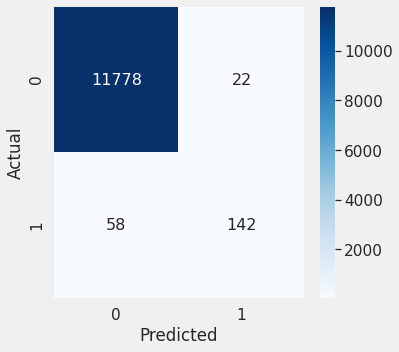

In [ ]:
data = confusion_matrix(y_test,predict_y_cv)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",fmt="d", annot=True,annot_kws={"size": 16})# font size


# Final Pipeline:

In [48]:
def normalise(data):
    X=data.values
    normalise=MinMaxScaler()
    normalise.fit(X)
    X=normalise.transform(X)
    data= pd.DataFrame(X, columns=data.columns,index=data.index)
    return data
    

In [49]:
sensors=[l for l in df.columns if 'histogram' in l]
def time_sensors_LSTM_input(data):
    X_test_time=data[sensors]
    sensor7_test=X_test_time[col_sen_7]
    sensor24_test=X_test_time[col_sen_24]
    sensor25_test=X_test_time[col_sen_25]
    sensor26_test=X_test_time[col_sen_26]
    sensor64_test=X_test_time[col_sen_64]
    sensor69_test=X_test_time[col_sen_69]
    sensor105_test=X_test_time[col_sen_105]
    
    X_test_LSTM=[]
    for i in range (len(X_test_time)):
        input_at_one_time=[]
        input_at_one_time.append(sensor7_test.values[i])
        input_at_one_time.append(sensor24_test.values[i])
        input_at_one_time.append(sensor25_test.values[i])
        input_at_one_time.append(sensor26_test.values[i])
        input_at_one_time.append(sensor64_test.values[i])
        input_at_one_time.append(sensor69_test.values[i])
        input_at_one_time.append(sensor105_test.values[i])
        X_test_LSTM.append(input_at_one_time)

    X_test_LSTM=np.array(X_test_LSTM)
    
    return X_test_LSTM


def non_time_sensors(data):
    X_test_non_time_sensors=data.drop(sensors,axis=1)
    
    return X_test_non_time_sensors
    

In [50]:
def pipeline_without_Y(data):
    data=pd.DataFrame([data])


    #loading pre trained models
    lstm_model=load_model('/content/drive/My Drive/case_study_model_1.h5')
    model=load_model('/content/drive/My Drive/case_study_model_2.h5')
    model_final = load_model('/content/drive/My Drive/case_study_model_3.h5')


    #preprocessing the data 
    #dropping the columns with most number of nan and very less unique value
    na_col=['id','sensor43_measure','sensor42_measure','sensor41_measure','sensor40_measure','sensor68_measure','sensor2_measure','sensor39_measure','sensor38_measure','sensor37_measure','sensor36_measure','sensor54_measure']
    data=data.drop(columns=na_col,axis=1)
    data=data.fillna(data.median())
    # normalise the data
    data=normalise(data)
    
    #getting the LSTM input
    LSTM_input=time_sensors_LSTM_input(data)
    non_time_input=non_time_sensors(data)
    
    lstm_test_output = lstm_model.predict(LSTM_input)
    

    dense_test_output = model.predict(non_time_input)
    
    
    temp1 = pd.DataFrame(lstm_test_output, columns=['dynamic_f1','dynamic_f2'])
    temp2 = pd.DataFrame(dense_test_output, columns=['static_f1','static_f2'])
    test_stage = pd.concat([temp1, temp2], axis=1)
    
    pred=model_final.predict_classes(test_stage )
    
    if pred[0]==0:
      return print(pred,'The fault has occured on the SURFACE')
    else:
      return print(pred,'The fault has occured in the DOWNHOLE')
    
    


In [62]:

def pipeline_with_Y(data,Y):
    data=pd.DataFrame([data])
    
    
    #Loading all the trained models 
    lstm_model=load_model('/content/drive/My Drive/case_study_model_1.h5')
    model=load_model('/content/drive/My Drive/case_study_model_2.h5')
    model_final = load_model('/content/drive/My Drive/case_study_model_3.h5')

    #preprocessing the data 
    #dropping the columns with most number of nan and very less unique value
    na_col=['id','sensor43_measure','sensor42_measure','sensor41_measure','sensor40_measure','sensor68_measure','sensor2_measure','sensor39_measure','sensor38_measure','sensor37_measure','sensor36_measure','sensor54_measure']
    data=data.drop(columns=na_col,axis=1)
    data=data.fillna(data.median())
    # normalise the data
    data=normalise(data)
    
    #getting the LSTM input
    LSTM_input=time_sensors_LSTM_input(data)
    non_time_input=non_time_sensors(data)
    
    lstm_test_output = lstm_model.predict(LSTM_input)
    
    dense_test_output = model.predict(non_time_input)
    
    
    temp1 = pd.DataFrame(lstm_test_output, columns=['dynamic_f1','dynamic_f2'])
    temp2 = pd.DataFrame(dense_test_output, columns=['static_f1','static_f2'])
    test_stage = pd.concat([temp1, temp2], axis=1)
    
    pred=model_final.predict_classes(test_stage )
    
    score=accuracy_score(Y,pred)
    
    
    return print('The accuracy of the prediction is :{} %'.format(score*100))


## Final Testing with an Single point :

In [59]:
x=df.drop(['target'],axis=1)
x_point=x.iloc[15000,:]
y=df['target']
y_point=[y.iloc[15000]]




# RESULT OF PIPELINE

In [60]:
pred=pipeline_without_Y(x_point)


[0] The fault has occured on the SURFACE


In [63]:
pred=pipeline_with_Y(x_point,y_point)


The accuracy of the prediction is :100.0 %
